In [2]:
import sigfig
import polars as pl
from refnx.analysis import Transform, GlobalObjective

import pyref.fitting as fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from typing import Any
from matplotlib.figure import Figure


# Load the Data Files


Dataset loaded from reflectivity_data.parquet


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

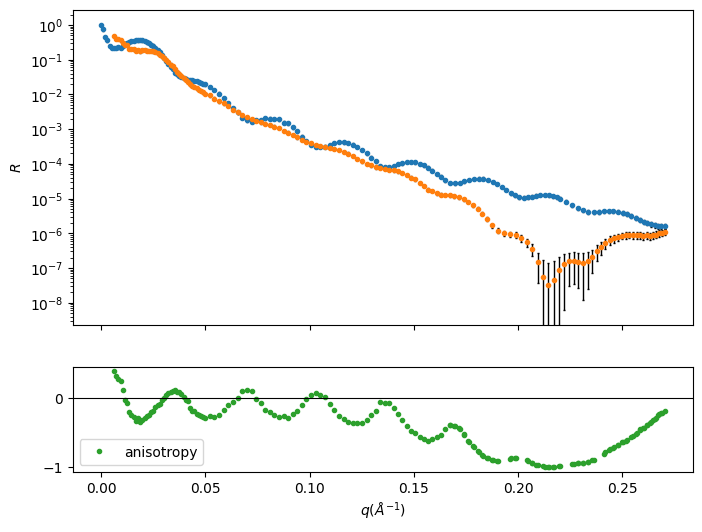

In [12]:
def save_reflectivity_dataset(data_dict, filename):
    """
    Save reflectivity dataset to a parquet file.

    Parameters
    ----------
    data_dict : dict
        Dictionary containing XrayReflectDataset objects with energy keys
    filename : str
        Output filename (should end with .parquet)
    """
    # Convert datasets to DataFrame format
    rows = []

    for energy_str, dataset in data_dict.items():
        energy = float(energy_str)

        # Extract Q, R, and dR arrays
        Q = dataset.data[0]  # x-axis (Q values)
        R = dataset.data[1]  # y-axis (reflectivity)
        dR = dataset.data[2]  # errors

        # Create rows for this energy
        for q, r, dr in zip(Q, R, dR):
            rows.append({"energy": energy, "Q": q, "R": r, "dR": dr})

    # Convert to polars DataFrame and save
    df_save = pl.DataFrame(rows)
    df_save.write_parquet(filename)
    print(f"Dataset saved to {filename}")


def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = 0.08 * R + 0.5e-6 * Q

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


# # Save the dataset to a parquet file
# save_reflectivity_dataset(data, "reflectivity_data.parquet")
# # Load the dataset back from the parquet file
data = load_reflectivity_dataset("reflectivity_data.parquet")
data["283.7"].plot(label="283.7 eV data")

# Load Optical Constants for Constraints and OOC instantiation


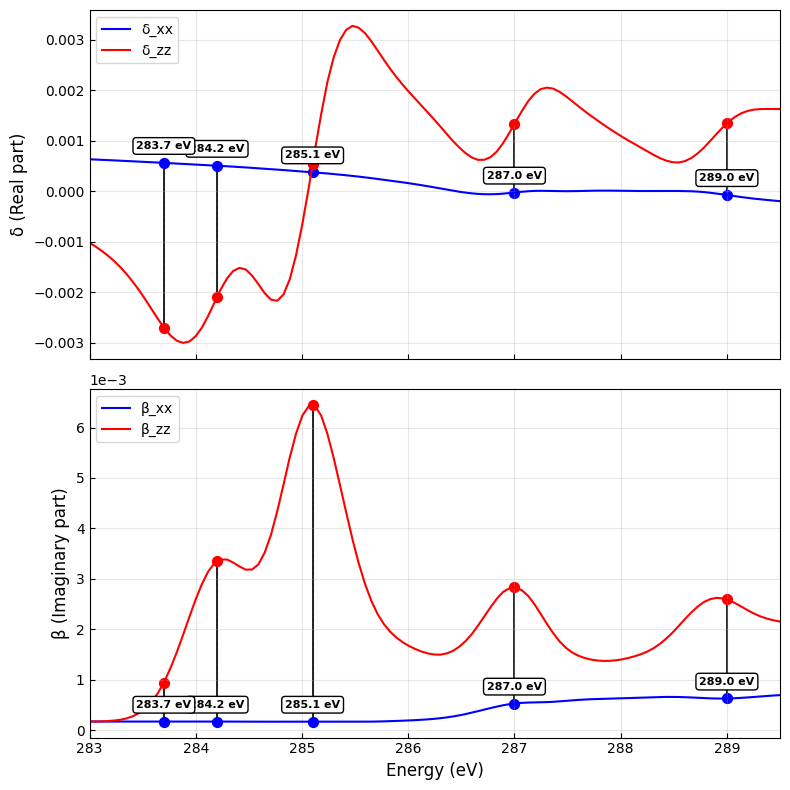

In [13]:
ooc = pd.read_csv("optical_constants.csv")
energy = [float(e) for e in loaded_data.keys()]


def ooc_function(energy, ooc=ooc, theta=0.0, density=1.0):
    """Get optical constants for a given energy."""
    #  return the interpolated values for a given energy
    n_xx = np.interp(energy, ooc["energy"], ooc["n_xx"]) * density
    n_zz = np.interp(energy, ooc["energy"], ooc["n_zz"]) * density
    n_ixx = np.interp(energy, ooc["energy"], ooc["n_ixx"]) * density
    n_izz = np.interp(energy, ooc["energy"], ooc["n_izz"]) * density
    #  Rotate by theta
    if theta != 0.0:
        n_xx, n_zz = (
            0.5 * (n_xx * (1 + np.cos(theta) ** 2) + n_zz * np.sin(theta) ** 2),
            n_xx * np.sin(theta) ** 2 + n_zz * np.cos(theta) ** 2,
        )
        n_ixx, n_izz = (
            0.5 * (n_ixx * (1 + np.cos(theta) ** 2) + n_izz * np.sin(theta) ** 2),
            n_ixx * np.sin(theta) ** 2 + n_izz * np.cos(theta) ** 2,
        )
    return n_xx, n_zz, n_ixx, n_izz


def plot_optical_constants_with_energies(
    ooc,
    energy_batches,
    en_shift=-0.0,
    label=True,
    theta=0.0,
    density=1.0,
    show_theta_range=False,
):
    """
    Plot optical constants with energy markers and return figure and axes.

    Parameters:
    -----------
    ooc : pandas.DataFrame
        DataFrame containing optical constants data
    energy_batches : list
        List of energy arrays to mark on the plot
    """

    ooc_func = lambda e: ooc_function(e, ooc=ooc, theta=theta, density=density)  # noqa: E731
    if show_theta_range:
        ooc_func_low = lambda e: ooc_function(e, ooc=ooc, theta=0, density=density)  # noqa: E731
        ooc_func_high = lambda e: ooc_function(  # noqa: E731
            e, ooc=ooc, theta=np.pi / 2, density=density
        )

    # Create a cleaner plot with better layout - stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    emin = min(energy_batches) + en_shift - 10
    emax = max(energy_batches) + en_shift + 10
    # Create energy array for plotting
    energy_plot = np.linspace(emin, emax, 1000)

    # Calculate optical constants using ooc_func
    n_xx_plot = []
    n_zz_plot = []
    n_ixx_plot = []
    n_izz_plot = []

    for energy in energy_plot:
        n_xx, n_zz, n_ixx, n_izz = ooc_func(energy)
        n_xx_plot.append(n_xx)
        n_zz_plot.append(n_zz)
        n_ixx_plot.append(n_ixx)
        n_izz_plot.append(n_izz)

    # Plot the main curves
    ax1.plot(energy_plot, n_xx_plot, "b-", linewidth=1.5, label="δ_xx")
    ax1.plot(energy_plot, n_zz_plot, "r-", linewidth=1.5, label="δ_zz")
    ax1.set_ylabel("δ (Real part)", fontsize=12)
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(direction="in")

    ax2.plot(energy_plot, n_ixx_plot, "b-", linewidth=1.5, label="β_xx")
    ax2.plot(energy_plot, n_izz_plot, "r-", linewidth=1.5, label="β_zz")

    #  fill between for theta range if specified
    if show_theta_range:
        n_xx_low_plot = []
        n_xx_high_plot = []
        n_ixx_low_plot = []
        n_ixx_high_plot = []

        for energy in energy_plot:
            n_xx_low, _, n_ixx_low, _ = ooc_func_low(energy)
            n_xx_high, _, n_ixx_high, _ = ooc_func_high(energy)
            n_xx_low_plot.append(n_xx_low)
            n_xx_high_plot.append(n_xx_high)
            n_ixx_low_plot.append(n_ixx_low)
            n_ixx_high_plot.append(n_ixx_high)

        ax1.fill_between(
            energy_plot,
            n_xx_low_plot,
            n_xx_high_plot,
            color="blue",
            alpha=0.1,
        )

        ax2.fill_between(
            energy_plot,
            n_ixx_low_plot,
            n_ixx_high_plot,
            color="blue",
            alpha=0.1,
        )

    ax2.set_ylabel("β (Imaginary part)", fontsize=12)
    ax2.set_xlabel("Energy (eV)", fontsize=12)
    ax2.legend(loc="upper left")
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(direction="in")
    ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

    # Draw vertical lines at the measurement energies
    if not label:
        plt.tight_layout()
        return fig, (ax1, ax2)

    for i, e in enumerate(energy_batches):
        if e < 283.7:
            continue
        n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
        n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(
            e + en_shift
        )
        ax1.vlines(
            e,
            ymin=min(n_xx, n_zz),
            ymax=max(n_xx, n_zz),
            color="gray",
            linestyle="--",
            linewidth=0.8,
            alpha=0.5,
            zorder=0,
        )
        ax2.vlines(
            e,
            ymin=min(n_ixx, n_izz),
            ymax=max(n_ixx, n_izz),
            color="gray",
            linestyle="--",
            linewidth=0.8,
            alpha=0.5,
            zorder=0,
        )

        # Energy-shifted energies (solid red lines)
        ax1.vlines(
            e + en_shift,
            ymin=min(n_xx_shifted, n_zz_shifted),
            ymax=max(n_xx_shifted, n_zz_shifted),
            color="k",
            linestyle="-",
            linewidth=1.2,
            zorder=0,
        )
        ax2.vlines(
            e + en_shift,
            ymin=min(n_ixx_shifted, n_izz_shifted),
            ymax=max(n_ixx_shifted, n_izz_shifted),
            color="k",
            linestyle="-",
            linewidth=1.2,
            zorder=0,
        )

        ax1.scatter(
            e + en_shift,
            n_xx_shifted,
            color="blue",
            marker="o",
            s=50,
            label=f"δ_xx at {e + en_shift} eV",
        )
        ax1.scatter(
            e + en_shift,
            n_zz_shifted,
            color="red",
            marker="o",
            s=50,
            label=f"δ_zz at {e} eV",
        )
        ax2.scatter(
            e + en_shift,
            n_ixx_shifted,
            color="blue",
            marker="o",
            s=50,
            label=f"β_xx at {e} eV",
        )
        ax2.scatter(
            e + en_shift,
            n_izz_shifted,
            color="red",
            marker="o",
            s=50,
            label=f"β_zz at {e + en_shift} eV",
        )
        # if the energy is >= 283.7 eV annotate the point with a box and bold text
        if e >= 283.7:
            ax1.annotate(
                f"{e + en_shift:.1f} eV",
                (e + en_shift, n_xx_shifted),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=8,
                bbox=dict(
                    boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"
                ),
                fontweight="bold",
            )
            ax2.annotate(
                f"{e + en_shift:.1f} eV",
                (e + en_shift, n_ixx_shifted),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
                fontsize=8,
                bbox=dict(
                    boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"
                ),
                fontweight="bold",
            )
    # Adjust layout
    plt.tight_layout()

    return fig, (ax1, ax2)


# Call the function and show the plot
fig, axes = plot_optical_constants_with_energies(
    ooc, energy, en_shift=-0.0, theta=0, show_theta_range=False
)
for ax in axes:
    ax.set_xlim(283, 289.5)
plt.show()

In [14]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False, bounds=(2, 3))
    return slab


def sio2(energy, thick=8.22, rough=6.153, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=False, bounds=(1, 2.3))
    return slab


def contamination(energy, thick=4.4, rough=2, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.81, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(np.pi / 4, 7 * np.pi / 8))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=3.3, rough=1, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.8, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 4))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=191, rough=8.8, density=1.61):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=1.35, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(
    energy,
    offset=0,
):
    """Construct the slab."""
    offset_energy = round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy)
        | znpc(offset_energy)
        | contamination(offset_energy)
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy + offset}"
    return slab


stacks = {str(round(e, 1)): construct_slab(e) for e in energy}
stacks.keys()

dict_keys(['282.9', '281.6', '281.4', '289.0', '283.5', '282.0', '282.3', '275.0', '284.2', '282.7', '285.1', '281.2', '283.3', '287.0', '281.8', '280.0', '283.7', '282.5', '250.0', '283.1', '281.0'])

# Fit Delta Crossing to consistent slab model


In [15]:
def safely_setp(slab, param, **kwargs):
    """Safely set parameters."""
    #  Check if the vary = True while the constraint is not None
    if kwargs.get("vary", False) and kwargs.get("constraint") is not None:
        kwargs["vary"] = None
    if hasattr(slab, param):
        getattr(slab, param).setp(**kwargs)

In [16]:
#  Constrain the thickness and roughness of each layers to match between energies
for e in energy:
    if e == 283.7:
        continue
    for i, slab in enumerate(stacks[str(round(e, 1))]):
        slab.thick.setp(vary=None, constraint=stacks["283.7"][i].thick)
        slab.rough.setp(vary=None, constraint=stacks["283.7"][i].rough)
        safely_setp(
            slab.sld, "density", vary=None, constraint=stacks["283.7"][i].sld.density
        )
        safely_setp(
            slab.sld, "rotation", vary=None, constraint=stacks["283.7"][i].sld.rotation
        )

In [17]:
def plot(  # type: ignore
    obj,
    samples=0,
    model=None,
    ax=None,
    ax_anisotropy=None,
    color_err=("C0", "C1", "C2"),
    color_fit=("C0", "C1", "C2"),
    data_kwargs=None,
    model_kwargs=None,
    show_s=True,
    show_p=True,
    show_anisotropy=True,
):
    """
    Plot function that includes anisotropy information.

    Parameters
    ----------
    samples : int, optional
        Number of sample curves to plot from MCMC chain
    model : array-like, optional
        Model data to plot
    ax : matplotlib.Axes, optional
        Axes for reflectivity plot
    ax_anisotropy : matplotlib.Axes, optional
        Axes for anisotropy plot
    data_kwargs : dict, optional
        Keyword arguments for data plotting
    model_kwargs : dict, optional
        Keyword arguments for model plotting
    show_s : bool, optional
        Whether to show s-polarization data
    show_p : bool, optional
        Whether to show p-polarization data
    show_anisotropy : bool, optional
        Whether to show anisotropy plot

    Returns
    -------
    tuple
        (ax, ax_anisotropy) - matplotlib axes objects
    """
    import matplotlib.pyplot as plt

    if data_kwargs is None:
        data_kwargs = {}
    if model_kwargs is None:
        model_kwargs = {}

    # Set up axes
    if ax is None:
        if show_anisotropy:
            fig, axs = plt.subplots(
                nrows=2,
                sharex=False,
                figsize=(8, 6),
                gridspec_kw={"height_ratios": [3, 1]},
            )
            ax = axs[0]
            ax_anisotropy = axs[1]
        else:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax_anisotropy = None
    elif ax_anisotropy is None and show_anisotropy:
        # Get the figure from the provided axis
        fig = ax.figure
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)
        ax_anisotropy = fig.add_subplot(gs[1], sharex=ax)

    # Check if we have separate s and p polarization data
    has_separate_pol = hasattr(obj.data, "s") and hasattr(obj.data, "p")

    # Plot data
    if has_separate_pol:
        # Plot s-polarization if requested
        if show_s:
            ax.errorbar(
                obj.data.s.x,  # type: ignore
                obj.data.s.y,  # type: ignore
                obj.data.s.y_err,  # type: ignore
                label=f"{obj.data.name} s-pol" if obj.data.name else "s-pol",
                marker="o",
                color=color_err[0],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate s-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "s"
            s_model = obj.model(obj.data.s.x)  # type: ignore
            ax.plot(
                obj.data.s.x,  # type: ignore
                s_model,
                color=color_fit[0],
                label="s-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol

        # Plot p-polarization if requested
        if show_p:
            ax.errorbar(
                obj.data.p.x,  # type: ignore
                obj.data.p.y,  # type: ignore
                obj.data.p.y_err,  # type: ignore
                label=f"{obj.data.name} p-pol" if obj.data.name else "p-pol",
                marker="o",
                color=color_err[1],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate p-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "p"
            p_model = obj.model(obj.data.p.x)  # type: ignore
            ax.plot(
                obj.data.p.x,  # type: ignore
                p_model,
                color=color_fit[1],
                label="p-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol
    else:
        # Handle combined data case
        ax.errorbar(
            obj.data.x,
            obj.data.y,
            obj.data.y_err,
            label=obj.data.name,
            marker="o",
            color=color_err[0],
            ms=3,
            lw=0,
            elinewidth=1,
            capsize=1,
            ecolor="k",
            **data_kwargs,
        )

        # Plot combined model
        model = obj.generative()
        _, _, model_transformed = obj._data_transform(model=model)

        if samples > 0:
            # Get sample curves from MCMC chain
            models = []
            for curve in obj._generate_generative_mcmc(ngen=samples):
                _, _, model_t = obj._data_transform(model=curve)
                models.append(model_t)
            models = np.array(models)

            # Show 1-sigma and 2-sigma confidence intervals
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 16, axis=0),  # type: ignore
                np.percentile(models, 84, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.5,
            )
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 2.5, axis=0),  # type: ignore
                np.percentile(models, 97.5, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.2,
            )

        # Plot the fit
        ax.plot(
            obj.data.x,
            model_transformed,  # type: ignore
            color=color_fit[1],
            label="fit",
            zorder=20,
            **model_kwargs,
        )

    # Plot anisotropy if enabled
    if (
        ax_anisotropy is not None
        and show_anisotropy
        and hasattr(obj.data, "anisotropy")
    ):
        ax_anisotropy.set_ylabel("Anisotropy")

        # Plot anisotropy model
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.model.anisotropy(obj.data.anisotropy.x),  # type: ignore
            color=color_fit[2],
            zorder=20,
            label="model",
        )

        # Plot anisotropy data
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.data.anisotropy.y,  # type: ignore
            color=color_err[2],
            marker="o",
            markersize=3,
            linestyle="None",
            label="data",
        )

        ax_anisotropy.legend()
        ax_anisotropy.axhline(0, color="k", ls="-", lw=plt.rcParams["axes.linewidth"])
        ax_anisotropy.set_xlabel(r"$q (\AA^{-1})$")

    # Finalize styling
    ax.set_ylabel("Reflectivity")
    ax.set_yscale("log")
    ax.legend()

    return ax, ax_anisotropy


def plot_reflectivity_and_structure(global_obj, figsize=(12, 10)) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a global objective.

    Parameters:
    -----------
    global_obj : GlobalObjective
        The global objective containing multiple objectives
    stacks : dict
        Dictionary of structure stacks with energy keys
    energy_labels : list, optional
        List of energy labels for plotting. If None, uses stack keys.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = global_obj.objectives
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
    )

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        plot(
            o,
            ax=ax[i][0],
            show_anisotropy=False,
            color_fit=("k", "k", "k"),
            model_kwargs={"lw": 0.5},
        )
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            energy_labels[i],
            transform=ax[i][0].transAxes,
            fontsize=11,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        # Custom legend for reflectivity
        if i == 0:
            ax[i][0].legend(
                ["s-pol", "p-pol"],
                loc="upper right",
                frameon=True,
                fancybox=False,
                fontsize=10,
            )
        else:
            if ax[i][0].get_legend():
                ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)

        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )

        # Remove individual legends except for the top structure plot
        if i == 0:
            ax[i][1].legend(
                loc="upper center",
                ncol=2,
                fontsize=9,
                frameon=True,
                fancybox=False,
            )
        else:
            if ax[i][1].get_legend():
                ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)", fontsize=12, fontweight="bold")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        ax[i][1].set_ylabel(None, fontsize=12, fontweight="bold")
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)", fontsize=12, fontweight="bold")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax


In [19]:
import pickle

with open("fitting_results_fixed.pkl", "rb") as f:
    _obj = pickle.load(f)

models = {str(e): o.model for e, o in zip(energy, _obj.objectives)}
for name, model in models.items():
    if float(name) not in energy:
        model.bkg = 0
    # Constrain the energy offset to be the same for all models
    model.scale_p.setp(vary=True, bounds=(0.5, 2))
    model.scale_s.setp(vary=True, bounds=(0.5, 2))

    if model.name.endswith("283.7"):
        model.energy_offset.setp(vary=False, value=-0.00173561, bounds=(-0.5, 0.5))
    else:
        model.energy_offset.setp(vary=None, constraint=models["283.7"].energy_offset)
objectives = [
    fit.AnisotropyObjective.build_objective(models[str(e)], data[str(e)])
    for e in energy
]

for objective in objectives:
    objective.transform = Transform("logY")

obj = fit.GlobalObjective(objectives)
print(obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1.05948 +/- 0.0127, bounds=[0.5, 2.0]>
<Parameter:   'scale_p'   , value=1.19571 +/- 0.0142, bounds=[0.5, 2.0]>
<Parameter:'theta_offset_s', value=0.662073 +/- 0.0145, bounds=[-0.8, 0.8]>
<Parameter:'theta_offset_p', value=0.388209 +/- 0.0149, bounds=[-0.8, 0.8]>
<Parameter:'Surface_283.7_thick', value=5.53154 +/- 0.323, bounds=[0.0, 12.0]>
<Parameter:'Surface_283.7_rough', value=4.41162 +/- 0.146, bounds=[0.0, 5.0]>
<Parameter:'Surface_283.7_density', value=1.46552 +/- 0.0326, bounds=[1.0, 1.8]>
<Parameter:'Surface_283.7_rotation', value=0.801591 +/- 0.457, bounds=[0.0, 1.5707963267948966]>
<Parameter:'ZnPc_283.7_thick', value=183.323 +/- 0.395, bounds=[180.0, 210.0]>
<Parameter:'ZnPc_283.7_rough', value=12.8186 +/- 0.24 , bounds=[2.0, 16.0]>
<Parameter:'ZnPc_283.7_density', value=1.6536 +/- 0.00665, bounds=[1.2, 1.8]>
<Parameter:'ZnPc_283.7_ro

/tmp/ipykernel_337470/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


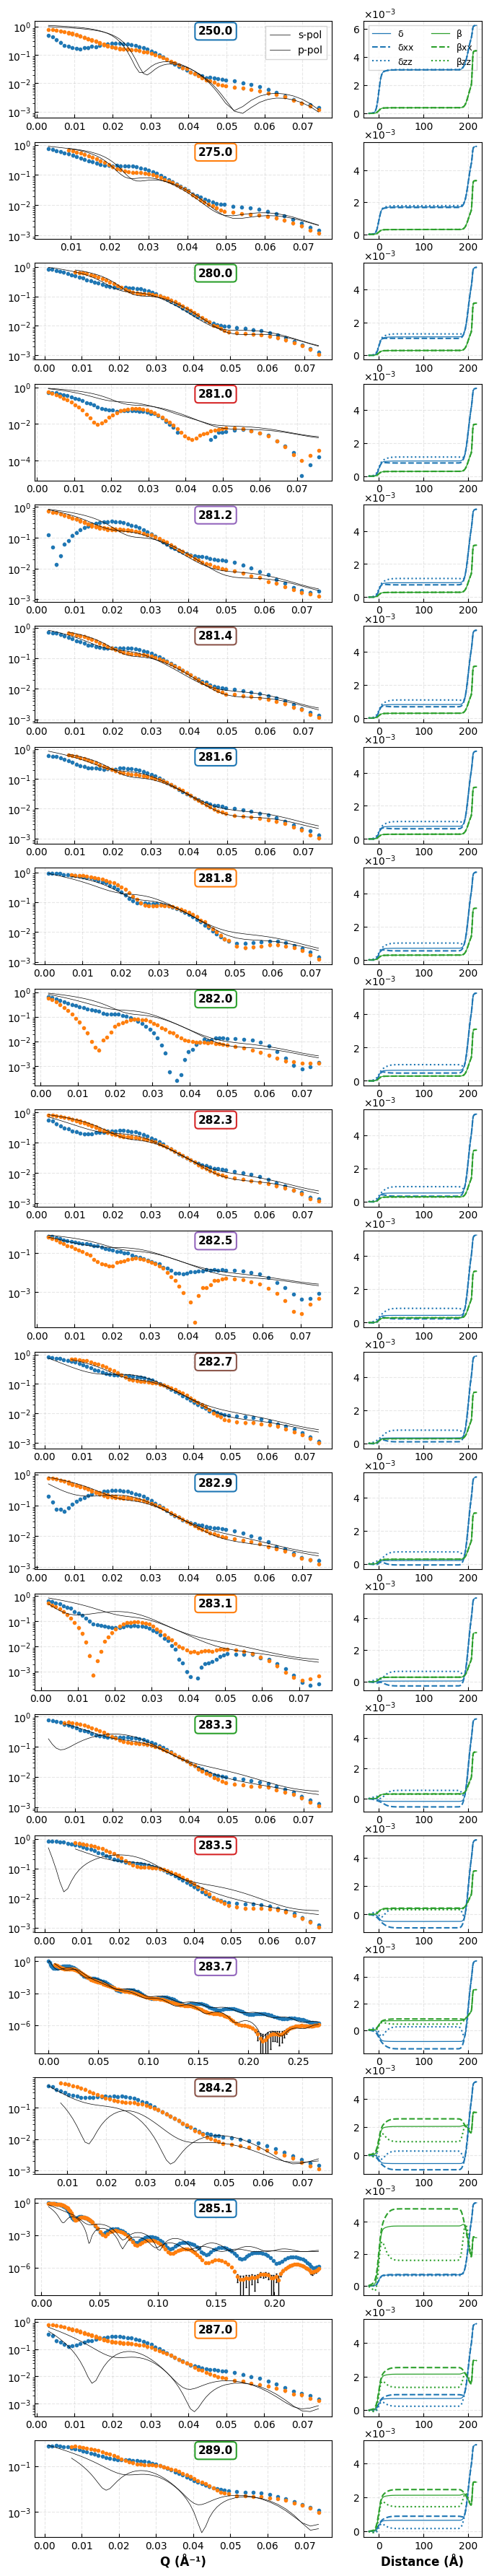

In [20]:
plot_reflectivity_and_structure(obj, figsize=(8, 2 * len(obj.objectives)))
plt.show()

In [21]:
from typing import TypeVar
import copy
from os import cpu_count

T = TypeVar("T")
CPU = cpu_count() // 2 if cpu_count() > 2 else 1


def fitting(
    obj: T, recursion_limit=2, workers=CPU, *, mcmc=False, **kwargs
) -> tuple[T, fit.CurveFitter]:
    """
    Fit the model to the data using the provided objective.

    Parameters
    ----------
    obj : T
        The objective function to minimize (can be AnisotropyObjective or GlobalObjective).
    recursion_limit : int, optional
        The number of times to recursively fit using differential evolution before refining with L-BFGS-B. Default is 2.
    workers : int, optional
        The number of parallel workers to use for fitting. Default is -1 (use all available).
    mcmc : bool, optional
        If True, perform MCMC sampling after fitting. Default is False.
    **kwargs : dict
        Additional keyword arguments for the fitter.

    Returns
    -------
    tuple[T, fit.CurveFitter]
        The fitted objective and the fitter used.
    """

    objective: T = copy.deepcopy(obj)
    fitter: fit.CurveFitter = fit.CurveFitter(
        objective,
    )
    kwargs = {"options": {"workers": workers, "maxiter": 1000}}
    fitter.fit(
        "differential_evolution", target="nll", workers=workers, updating="deferred"
    )
    fit.fitters._fix_bounds(objective, by_bounds=True)
    fitter.fit(target="nll", **kwargs)
    for i in range(recursion_limit):
        fitter.fit(target="nlpost", **kwargs)
        fit.fitters._fix_bounds(objective, by_bounds=True)
    return objective, fitter

In [ ]:
fit_obj, fitter_ani = fitting(obj)

0it [00:00, ?it/s]

/tmp/ipykernel_18975/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


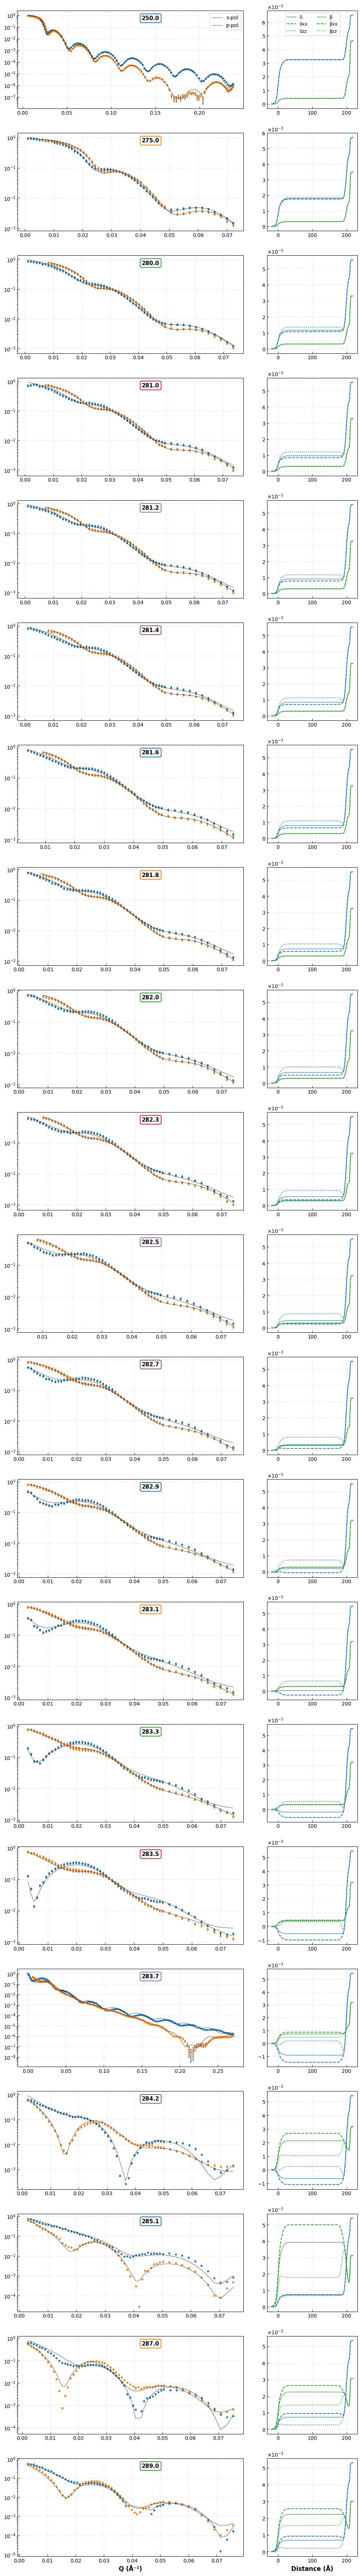

In [ ]:
from typing import Any


from matplotlib.figure import Figure

f_obj = fit.GlobalObjective([o for o in fit_obj.objectives if o.model.energy == 283.7])


plot_reflectivity_and_structure(fit_obj, figsize=(12, 4 * len(fit_obj.objectives)))
plt.show()

In [47]:
print(fit_obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=1.03665 +/- 0.013, bounds=[0.29000000000000004, 1.79]>
<Parameter:   'scale_p'   , value=1.16272 +/- 0.0138, bounds=[0.4099999999999999, 1.91]>
<Parameter:'theta_offset_s', value=0.590962 +/- 0.0163, bounds=[-0.21000000000000008, 1.3900000000000001]>
<Parameter:'theta_offset_p', value=0.36517 +/- 0.0169, bounds=[-0.43000000000000005, 1.17]>
<Parameter:'Surface_283.7_thick', value=2.31721 +/- 0.468, bounds=[0.0, 5.574999999999999]>
<Parameter:'Surface_283.7_rough', value=1.82616 +/- 2.39 , bounds=[0.0, 4.025]>
<Parameter:'Surface_283.7_density', value=0.6 +/- 0.169, bounds=[0.19999999999999996, 1.0]>
<Parameter:'Surface_283.7_rotation', value=0.955317 +/- 0.0333, bounds=[0.9553166181245093, 1.5707963267948966]>
<Parameter:'ZnPc_283.7_thick', value=190.353 +/- 0.63 , bounds=[0.0, 336.975]>
<Parameter:'ZnPc_283.7_rough', value=9.66429 +/- 0.568, bo

/tmp/ipykernel_637440/3489775038.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


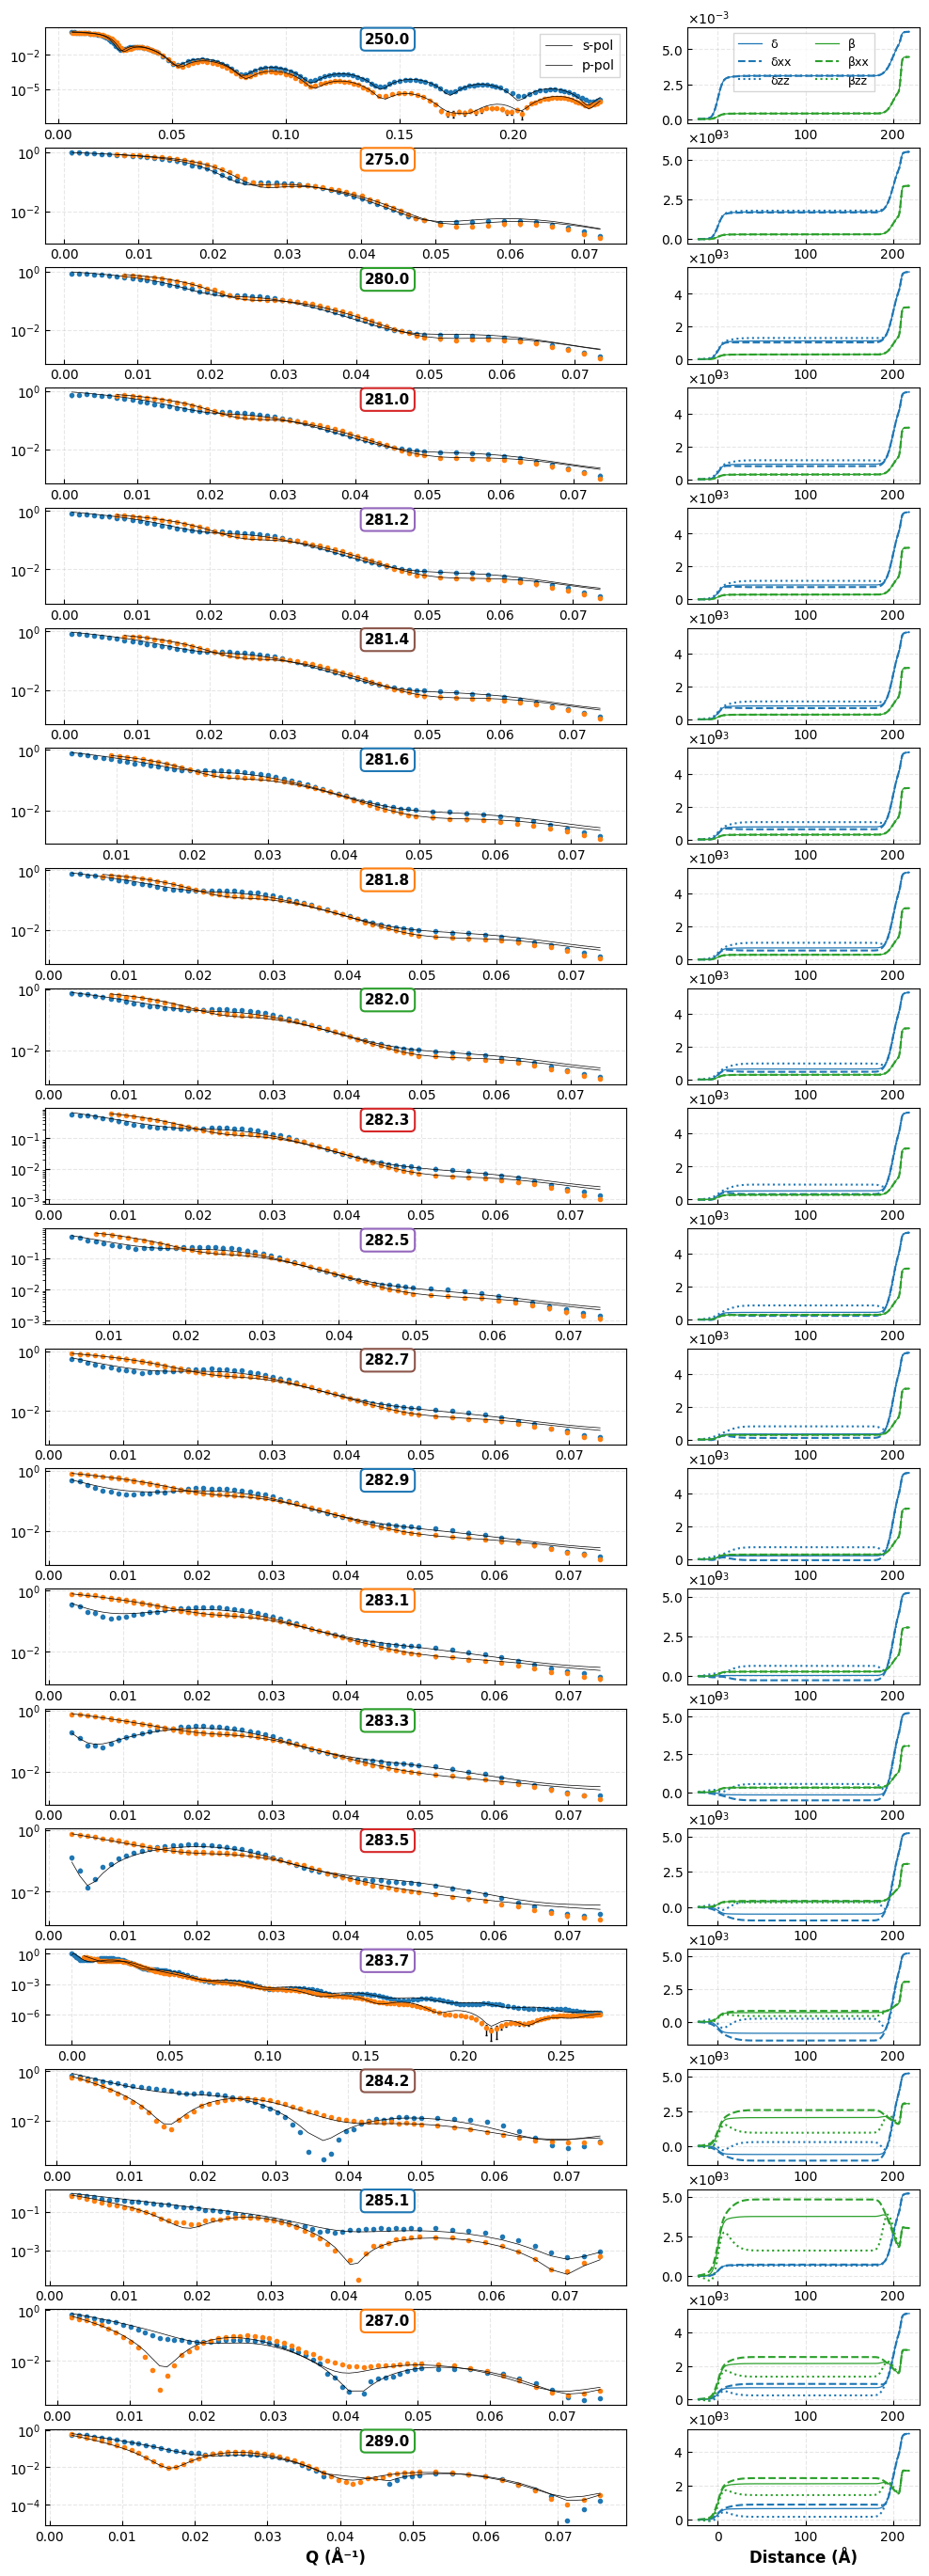

In [26]:
#  Load the older fitting results
import pickle

with open("fitting_results_fixed.pkl", "rb") as f:
    fit_obj = pickle.load(f)

#  Plot the results
plot_reflectivity_and_structure(fit_obj, figsize=(12, 4 * 8))
plt.show()

In [45]:
from refnx.analysis import Parameters


def all_parameters(parameter_group):
    if isinstance(parameter_group, Parameters):
        params = []
        for param in parameter_group:
            params.extend(all_parameters(param))
        return params
    else:
        return [parameter_group]

In [46]:
def structure_params(fit_objectives, structure_property):
    """Get the structure parameters from the fit objectives."""
    #  Iterate over the obectives and grab the structure parameters
    params = []
    for objective in fit_objectives.objectives:
        for slab in objective.model.structure:
            if structure_property in ["density", "rotation"]:
                if hasattr(slab, "sld") and hasattr(slab.sld, structure_property):
                    param = getattr(slab.sld, structure_property)
                    if param.vary:
                        params.append(param)
            if hasattr(slab, structure_property):
                param = getattr(slab, structure_property)
                if param.vary:
                    params.append(param)
    return params


def print_structure_params(fit_objectives, structure_property):
    """Print the structure parameters from the fit objectives."""
    params = structure_params(fit_objectives, structure_property)
    print(f"Number of {structure_property} parameters: {len(params)}")
    print("-" * 82)
    for param in params:
        color = (
            "\033[94m" if param.vary else "\033[91m"
        )  # Light blue for vary=True, red for vary=False
        reset_color = "\033[0m"  # Reset to default color
        #  Round the param bounds to 3 decimal places
        bounds = (
            f"({param.bounds.lb:.3f}, {param.bounds.ub:.3f})"
            if param.bounds is not None
            else "(None, None)"
        )
        val = param.value
        err = param.stderr if param.stderr else 0
        print(
            f"{color}| {param.name:30} | {val:10.3f} ± {err:8.3f} | {str(bounds):18}{reset_color} |"
        )
    print("-" * 82)


print_structure_params(fit_obj, "thick")
print_structure_params(fit_obj, "rough")
print_structure_params(fit_obj, "density")
print_structure_params(fit_obj, "rotation")

Number of thick parameters: 4
----------------------------------------------------------------------------------
| Surface_283.7_thick            |      6.082 ±    0.463 | (0.000, 12.000)    |
| ZnPc_283.7_thick               |    181.601 ±    0.634 | (180.000, 210.000) |
| Contamination_283.7_thick      |     12.000 ±    0.525 | (0.000, 12.000)    |
| Oxide_283.7_thick              |      9.687 ±    0.152 | (8.000, 12.000)    |
----------------------------------------------------------------------------------
Number of rough parameters: 4
----------------------------------------------------------------------------------
| Surface_283.7_rough            |      4.849 ±    0.226 | (0.000, 5.000)     |
| ZnPc_283.7_rough               |     12.564 ±    0.293 | (2.000, 16.000)    |
| Contamination_283.7_rough      |      5.000 ±    0.634 | (0.000, 5.000)     |
| Oxide_283.7_rough              |      5.564 ±    0.088 | (0.000, 8.000)     |
---------------------------------------------------

In [ ]:
np.degrees(0.744), np.degrees(1.210), np.degrees(0.912)

(np.float64(42.62805995773325),
 np.float64(69.32789321082961),
 np.float64(52.25375091593108))

In [ ]:
np.pi / 2

1.5707963267948966

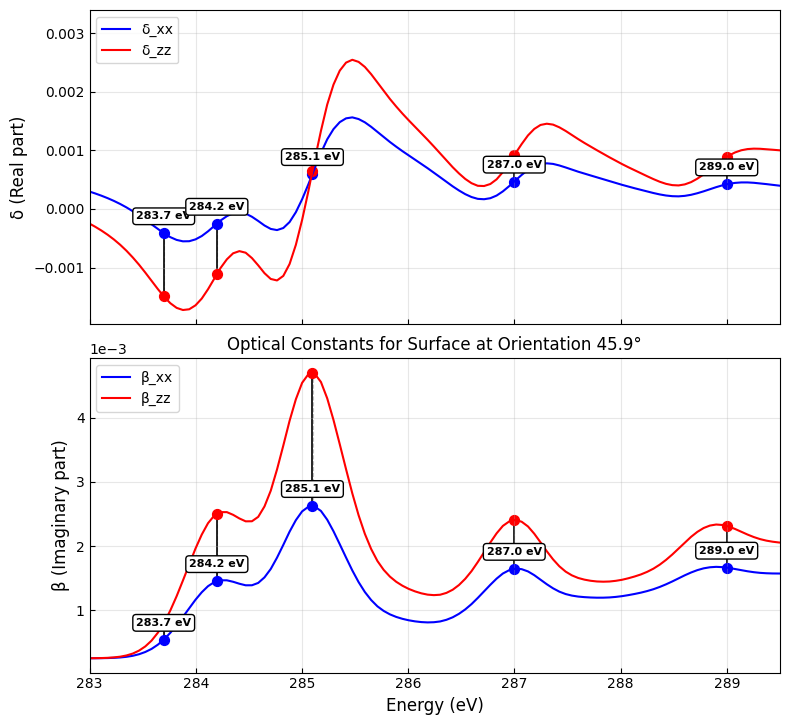

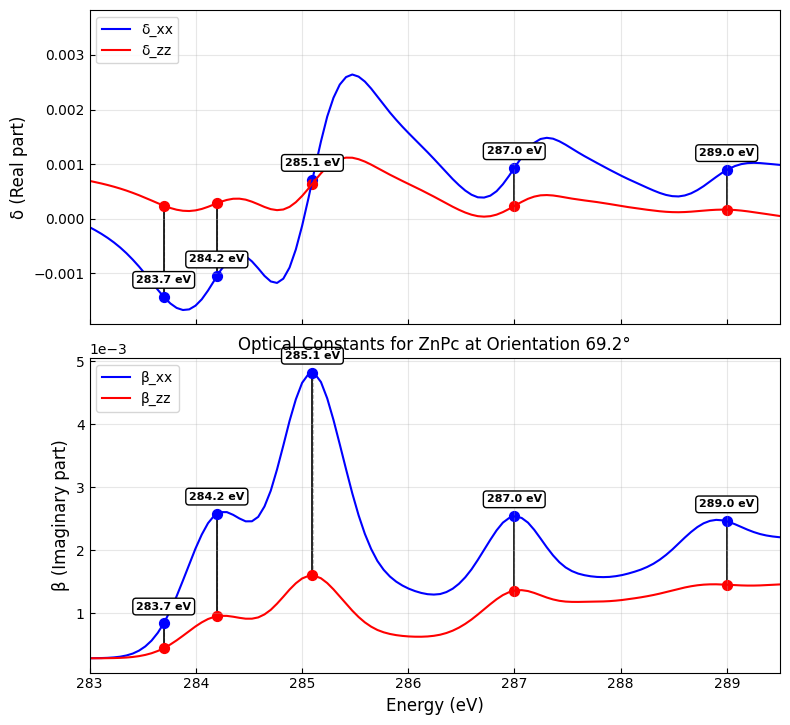

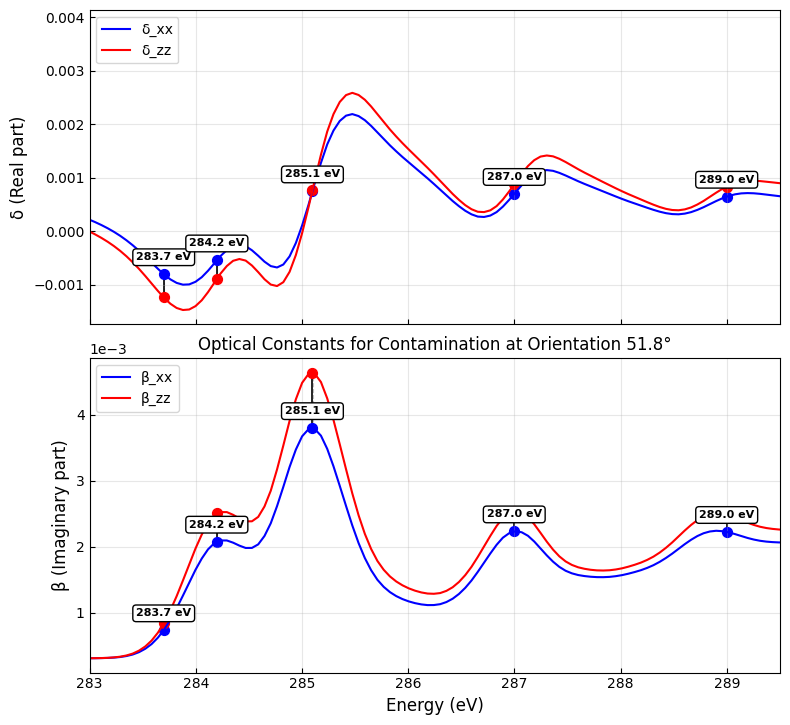

In [ ]:
#  Get the orientation of each layer
orient = {}
densities = {}
for objective in fit_obj.objectives:
    for slab in objective.model.structure:
        slab_name = slab.name.split("_")[0]  # Get the slab name without the energy
        if hasattr(slab, "sld") and hasattr(slab.sld, "rotation"):
            if slab.sld.rotation.vary:
                orient[slab_name] = slab.sld.rotation.value
            if hasattr(slab.sld, "density") and slab.sld.density.vary:
                densities[slab_name] = slab.sld.density.value

energy_offset = fit_obj.objectives[0].model.energy_offset.value

#  For each slab, plot the optical constants
for slab_name, orientation in orient.items():
    plot_optical_constants_with_energies(
        ooc,
        energy_batches[1],
        en_shift=energy_offset,
        label=True,
        theta=orientation,
        density=densities.get(slab_name, 1.61),
        show_theta_range=False,
    )
    #  Set the x range and add a title
    plt.xlim(283, 289.5)
    plt.title(
        f"Optical Constants for {slab_name} at Orientation {np.degrees(orientation):.1f}°"
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    #  Show the plot
plt.show()


In [ ]:
#  Fix the thickness, and roughness of all layers to the 283.7 eV values
def fix_structure_parameters(fit_objectives, structure_property):
    """Get the structure parameters from the fit objectives."""
    #  Iterate over the obectives and grab the structure parameters
    import copy

    objective = copy.deepcopy(fit_objectives)
    for obj in objective.objectives:
        for slab in obj.model.structure:
            if structure_property == "density":
                if hasattr(slab, "sld") and hasattr(slab.sld, structure_property):
                    param = getattr(slab.sld, structure_property)
                    if param.vary:
                        param.setp(vary=False)
            if hasattr(slab, structure_property):
                param = getattr(slab, structure_property)
                if param.vary:
                    param.setp(vary=False)
    return objective


obj_fixed = fix_structure_parameters(fit_obj, "thick")
obj_fixed = fix_structure_parameters(obj_fixed, "rough")

#  Fix the density for the Si and SiO2 layers to the 283.7 eV values
for obj in obj_fixed.objectives:
    if obj.model.structure[-1].sld.density.vary:
        obj.model.structure[-1].sld.density.setp(vary=False, value=2.33)
    if obj.model.structure[-2].sld.density.vary:
        obj.model.structure[-2].sld.density.setp(vary=False)

print_structure_params(obj_fixed, "thick")
print_structure_params(obj_fixed, "rough")
print_structure_params(obj_fixed, "density")
print_structure_params(obj_fixed, "rotation")

Number of thick parameters: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Number of rough parameters: 0
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
Number of density parameters: 3
----------------------------------------------------------------------------------
| Surface_283.7_density          |      1.466 ±    0.033 | (1.000, 1.800)     |
| ZnPc_283.7_density             |      1.654 ±    0.007 | (1.200, 1.800)     |
| Contamination_283.7_density    |      1.800 ±    0.015 | (1.000, 1.800)     |
----------------------------------------------------------------------------------
Number of rotation parameters: 3
----------------------------------------------------------------------------------
| Surface_283.7_rotation         |      0.802 ±    0.4

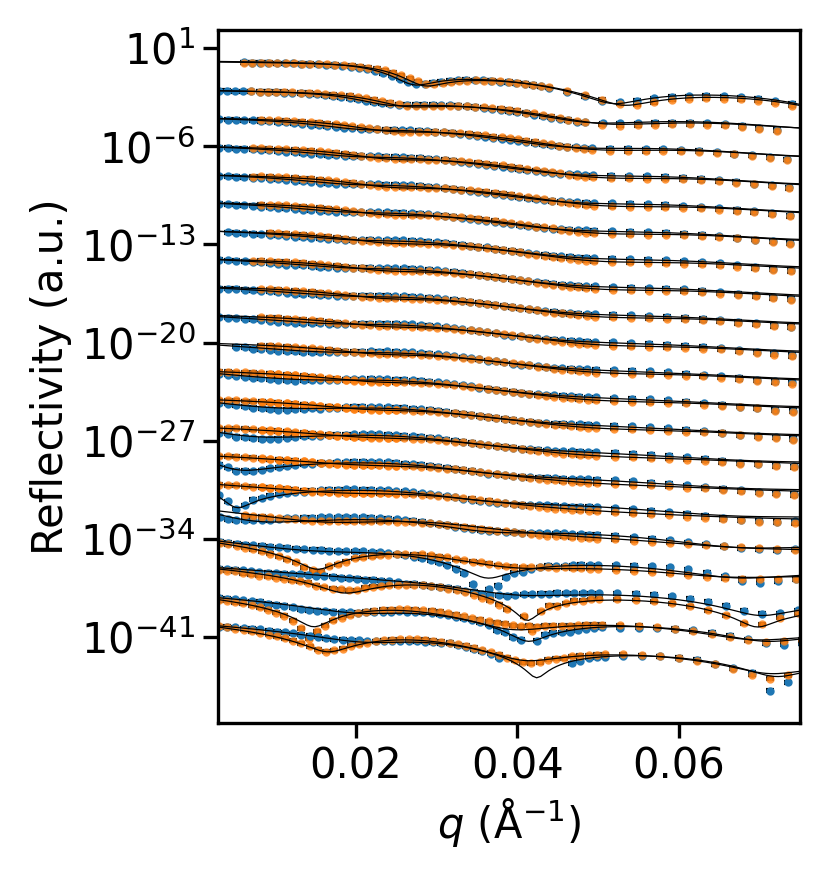

In [ ]:
q = np.linspace(0.001, 0.25, 500)
fig, ax = plt.subplots(figsize=(2.5, 3), dpi=300)
used_energy = []

# Iterate over the objectives from the global fit object
for i, objective in enumerate(fit_obj.objectives):
    model = objective.model
    e = model.energy
    # print(model)
    d = objective.data

    # Calculate model reflectivity for s and p polarizations
    model_s = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)
    model_p = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)

    # Plot experimental data with an offset for clarity
    offset = 100**-i
    ax.errorbar(
        d.s.x,
        d.s.y * offset,
        d.s.y_err * offset,
        marker="o",
        color="C0",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="s-pol" if i == 1 else None,
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y * offset,
        d.p.y_err * offset,
        marker="o",
        color="C1",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="p-pol" if i == 1 else None,
        zorder=-1,
        alpha=0.8,
    )

    # Plot the fit lines
    ax.plot(
        q,
        model_s * offset,
        color="k",
        lw=0.3,
        zorder=2,
        label="fit" if i == 1 else None,
    )
    ax.plot(q, model_p * offset, color="k", lw=0.3, zorder=2)

# Main plot formatting
ax.set_yscale("log")
ax.set_xlim(0.003, 0.075)
# ax.set_ylim(1e-8)
ax.set_xlabel(r"$q\ (\mathrm{\AA}^{-1})$", labelpad=2)
ax.set_ylabel("Reflectivity (a.u.)", labelpad=2)
ax.tick_params(axis="both", which="both", pad=2, width=0.8)

# Improve legend positioning and content
handles, labels = ax.get_legend_handles_labels()
if handles:  # Ensure legend is only created if there are labels
    order = [0, 2, 1]  # Reorder: s-pol, fit, p-pol
    # ax.legend(
    #     [handles[idx] for idx in order],
    #     [labels[idx] for idx in order],
    #     loc=(0.1, 0.0625),
    #     handletextpad=1,
    #     edgecolor="k",
    # )

plt.show()

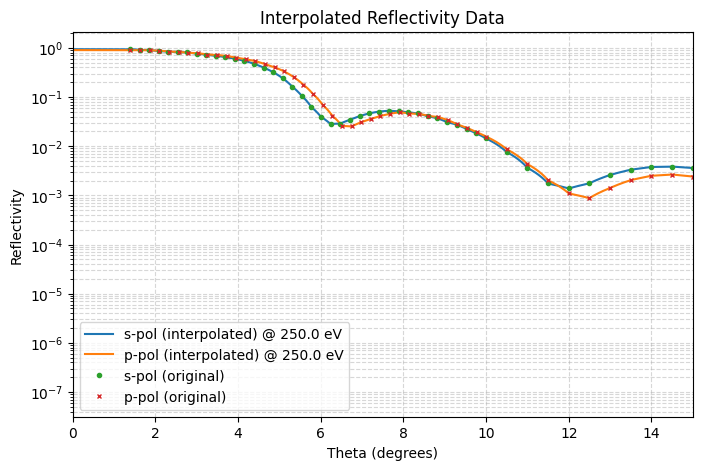

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Constants for q to theta conversion
hc = 12398.4198  # eV·Å


def q_to_theta(q, energy):
    """Convert q (in Å⁻¹) to theta (in degrees) for a given energy (in eV)."""
    # lambda (Å) = hc (eV·Å) / energy (eV)
    wavelength = hc / energy
    # q = (4 * pi / lambda) * sin(theta) => sin(theta) = q * lambda / (4 * pi)
    # np.arcsin can handle arrays
    theta_rad = np.arcsin(q * wavelength / (4 * np.pi))
    return np.degrees(theta_rad)


def theta_to_q(theta, energy):
    """Convert theta (in degrees) to q (in Å⁻¹) for a given energy (in eV)."""
    # lambda (Å) = hc (eV·Å) / energy (eV)
    wavelength = hc / energy
    # sin(theta) = q * lambda / (4 * pi) => q = (4 * pi / lambda) * sin(theta)
    theta_rad = np.radians(theta)
    return (4 * np.pi / wavelength) * np.sin(theta_rad)


# Find the global theta range across all datasets
min_theta = 0
max_theta = 60

for objective in fit_obj.objectives:
    energy = objective.model.energy
    # Combine s and p polarization q values
    q_values = np.concatenate((objective.data.s.x, objective.data.p.x))
    theta_values = q_to_theta(q_values, energy)
    current_min = np.min(theta_values)
    current_max = np.max(theta_values)
    if current_min < min_theta:
        min_theta = current_min
    # Use the tightest grouping
    if current_max < max_theta:
        max_theta = current_max

# Create a common theta grid
common_theta = np.linspace(min_theta, max_theta, 1000)

# Interpolate each dataset onto the common theta grid
interpolated_data = {}
for objective in fit_obj.objectives:
    energy = objective.model.energy

    # s-polarization
    theta_s = q_to_theta(objective.data.s.x, energy)
    # Sort by theta before interpolation
    sort_idx_s = np.argsort(theta_s)
    interp_s = np.interp(
        common_theta, theta_s[sort_idx_s], objective.data.s.y[sort_idx_s]
    )

    # p-polarization
    theta_p = q_to_theta(objective.data.p.x, energy)
    # Sort by theta before interpolation
    sort_idx_p = np.argsort(theta_p)
    interp_p = np.interp(
        common_theta, theta_p[sort_idx_p], objective.data.p.y[sort_idx_p]
    )

    interpolated_data[energy] = {"s": interp_s, "p": interp_p}

# Example: Plot the interpolated data for the first energy
first_energy = fit_obj.objectives[0].model.energy
plt.figure(figsize=(8, 5))
plt.plot(
    common_theta,
    interpolated_data[first_energy]["s"],
    label=f"s-pol (interpolated) @ {first_energy:.1f} eV",
)
plt.plot(
    common_theta,
    interpolated_data[first_energy]["p"],
    label=f"p-pol (interpolated) @ {first_energy:.1f} eV",
)

# For comparison, plot original data points
objective = fit_obj.objectives[0]
theta_s_orig = q_to_theta(objective.data.s.x, first_energy)
theta_p_orig = q_to_theta(objective.data.p.x, first_energy)
plt.plot(theta_s_orig, objective.data.s.y, "o", ms=3, label="s-pol (original)")
plt.plot(theta_p_orig, objective.data.p.y, "x", ms=3, label="p-pol (original)")

plt.yscale("log")
plt.xlabel("Theta (degrees)")
plt.ylabel("Reflectivity")
plt.xlim(common_theta[0], common_theta[-1])
plt.title("Interpolated Reflectivity Data")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

/tmp/ipykernel_166101/4156309142.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


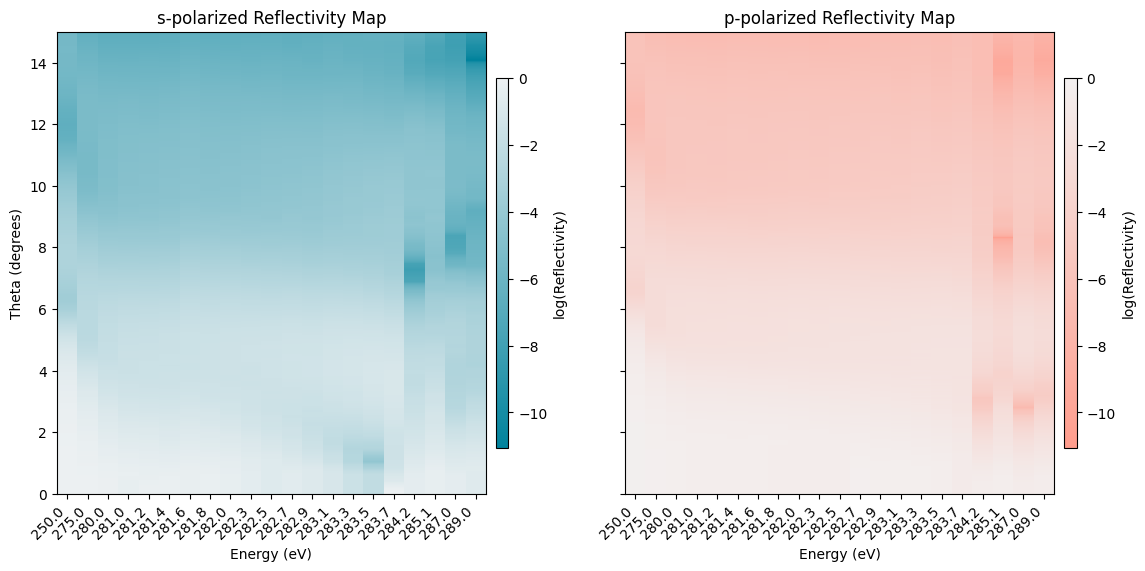

In [ ]:
import seaborn as sns

# Get the sorted list of energies from the interpolated data
energies = sorted(interpolated_data.keys())

# Initialize lists to store the interpolated data for each energy
s_reflectivity_list = []
p_reflectivity_list = []
s_reflectivity_model = []
p_reflectivity_model = []

# Populate the lists with the interpolated reflectivity values
for i, energy in enumerate(energies):
    model = fit_obj.objectives[i].model
    model_s = fit.ReflectModel(
        model.structure,
        energy=energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(theta_to_q(common_theta, energy))
    model_p = fit.ReflectModel(
        model.structure,
        energy=energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(theta_to_q(common_theta, energy))
    s_reflectivity_model.append(model_s)
    p_reflectivity_model.append(model_p)
    s_reflectivity_list.append(interpolated_data[energy]["s"])
    p_reflectivity_list.append(interpolated_data[energy]["p"])

# Convert the lists into 2D NumPy arrays
# Axis 0 corresponds to energy, and axis 1 corresponds to the common theta values
s_reflectivity_map = np.array(s_reflectivity_list)
p_reflectivity_map = np.array(p_reflectivity_list)
# Convert the model reflectivity lists into 2D NumPy arrays
s_reflectivity_model = np.array(s_reflectivity_model)
p_reflectivity_model = np.array(p_reflectivity_model)

# Calculate the log of the reflectivity maps
log_s_map = np.log(s_reflectivity_map)
log_p_map = np.log(p_reflectivity_map)

# Determine the global min and max for the color scale
vmin = min(log_s_map.min(), log_p_map.min())
vmax = max(log_s_map.max(), log_p_map.max())


# Create a figure with two subplots to visualize the 2D arrays
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1}
)
cmap_s = sns.color_palette("light:#00829c_r", as_cmap=True)
cmap_p = sns.color_palette("light:#ff9d8d_r", as_cmap=True)

# Plot the s-polarized reflectivity map
im1 = ax1.imshow(
    log_s_map.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(energies), common_theta.min(), common_theta.max()],
    cmap=cmap_s,
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)
ax1.set_title("s-polarized Reflectivity Map")
ax1.set_ylabel("Theta (degrees)")
ax1.set_xlabel("Energy (eV)")
#  Rotate the ticks on the x-axis
ax1.set_xticks(np.arange(len(energies)) + 0.5)
ax1.set_xticklabels([f"{e:.1f}" for e in energies], rotation=45, ha="right")
fig.colorbar(
    im1,
    ax=ax1,
    label="log(Reflectivity)",
    location="right",
    pad=0.02,
    shrink=0.8,
    aspect=30,
)
# Plot the p-polarized reflectivity map
im2 = ax2.imshow(
    log_p_map.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(energies), common_theta.min(), common_theta.max()],
    cmap=cmap_p,
    interpolation="none",
    vmin=vmin,
    vmax=vmax,
)
ax2.set_title("p-polarized Reflectivity Map")
ax2.set_xlabel("Energy (eV)")
ax2.set_xticks(np.arange(len(energies)) + 0.5)
ax2.set_xticklabels([f"{e:.1f}" for e in energies], rotation=45, ha="right")
fig.colorbar(
    im2,
    ax=ax2,
    label="log(Reflectivity)",
    location="right",
    pad=0.02,
    shrink=0.8,
    aspect=30,
)

plt.tight_layout()
plt.show()


/tmp/ipykernel_166101/2499907533.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


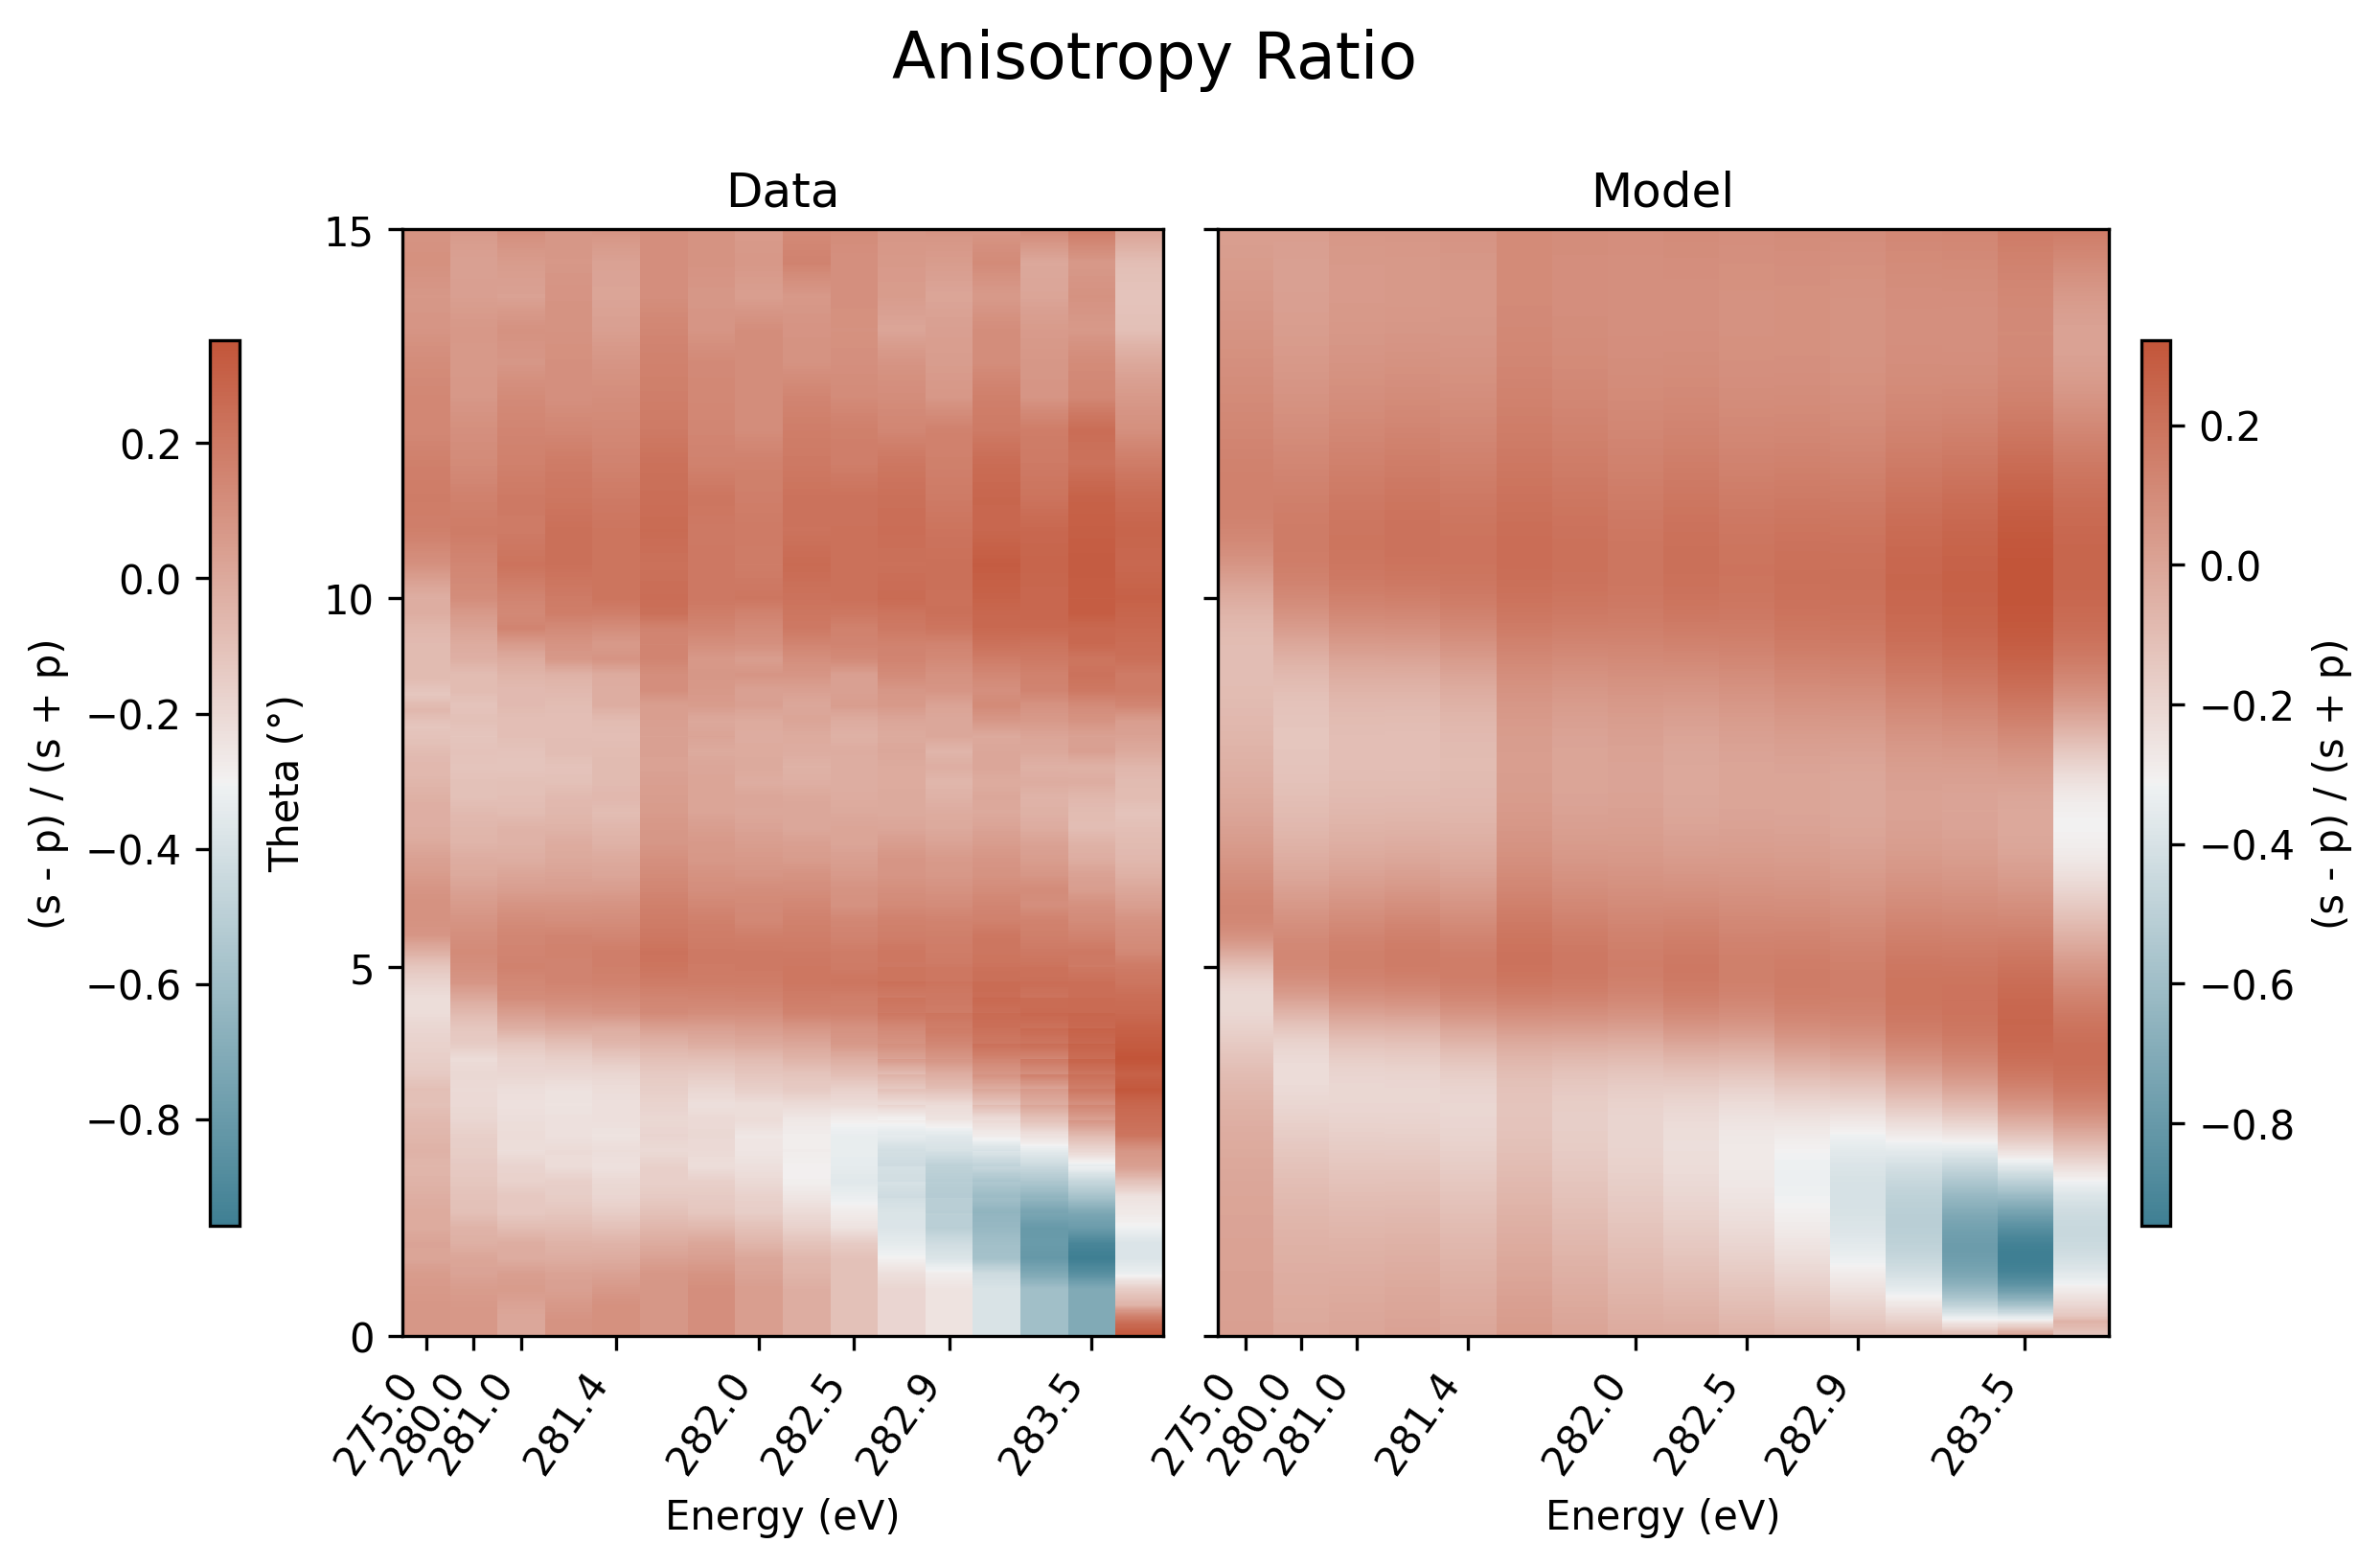

In [ ]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
anisotropy_ratio = (s_reflectivity_map - p_reflectivity_map) / (
    s_reflectivity_map + p_reflectivity_map
)
anisotropy_ratio_model = (s_reflectivity_model - p_reflectivity_model) / (
    s_reflectivity_model + p_reflectivity_model
)
energies = np.array(energies)

# Find indices for the desired energy range
energy_indices = np.where((energies >= 275) & (energies <= 283.7))[0]
select_energies = energies[energy_indices]
selected_anisotropy_ratio = anisotropy_ratio[energy_indices, :]
selected_anisotropy_ratio_model = anisotropy_ratio_model[energy_indices, :]

# now plot the anisotropy ratio for both data and model
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5), dpi=300, sharey=True, gridspec_kw={"wspace": 0.05}
)

# Plot experimental data anisotropy
im1 = ax1.imshow(
    selected_anisotropy_ratio.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(select_energies), common_theta.min(), common_theta.max()],
    cmap=cmap,
    interpolation="none",
)
ax1.set_title("Data")
ax1.set_ylabel("Theta (°)")
ax1.set_xlabel("Energy (eV)")

# Plot model anisotropy
im2 = ax2.imshow(
    selected_anisotropy_ratio_model.T,
    aspect="auto",
    origin="lower",
    extent=[0, len(select_energies), common_theta.min(), common_theta.max()],
    cmap=cmap,
    interpolation="none",
)
ax2.set_title("Model")
ax2.set_xlabel("Energy (eV)")


# Generate ticks every 0.5 eV
tick_positions = []
tick_labels = []
# Round to nearest 0.5
start_energy = np.round(select_energies[0] * 2) / 2
end_energy = np.round(select_energies[-1] * 2) / 2

for energy_val in np.arange(start_energy, end_energy + 0.5, 0.5):
    # Find the index of the closest energy in the select_energies array
    closest_idx = np.argmin(np.abs(select_energies - energy_val))
    # Add the tick position and label if it's not already there
    if closest_idx + 0.5 not in tick_positions:
        tick_positions.append(closest_idx + 0.5)
        tick_labels.append(f"{select_energies[closest_idx]:.1f}")

# Set the ticks and labels for the x-axis for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=55, ha="right")
    ax.set_yticks([0, 5, 10, 15])
    ax.tick_params(axis="both")

# Add colorbars
cbar1 = fig.colorbar(
    im1,
    ax=ax1,
    label="(s - p) / (s + p)",
    location="left",
    pad=0.15,
    shrink=0.8,
    aspect=30,
)
cbar2 = fig.colorbar(
    im2,
    ax=ax2,
    label="(s - p) / (s + p)",
    location="right",
    pad=0.03,
    shrink=0.8,
    aspect=30,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Anisotropy Ratio", fontsize=16, y=1.02)
plt.show()


In [ ]:
#  Now plot the model's anisotropic Ratio for each energy


/tmp/ipykernel_166101/1644857325.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


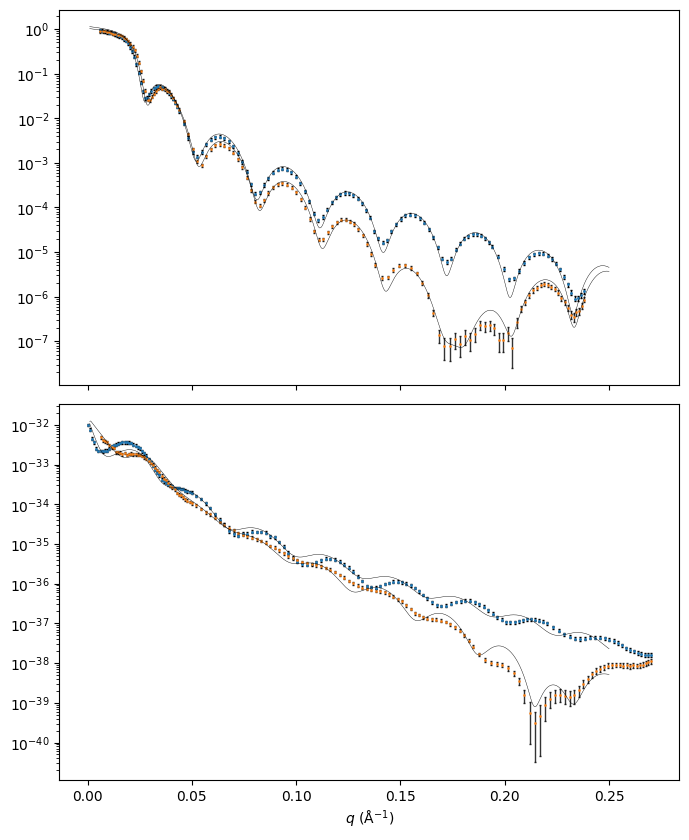

In [ ]:
fig, axes = plt.subplots(
    2, 1, figsize=(8, 10), sharex=True, gridspec_kw={"hspace": 0.05}
)
energies_to_plot = [250.0, 283.7]

for i, objective in enumerate(fit_obj.objectives):
    model = objective.model
    e = model.energy
    if e not in energies_to_plot:
        continue  # Skip energies not in the list
    j = energies_to_plot.index(e)
    # print(model)
    d = objective.data

    # Calculate model reflectivity for s and p polarizations
    model_s = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)
    model_p = fit.ReflectModel(
        model.structure,
        energy=e,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(q)

    # Plot experimental data with an offset for clarity
    offset = 100**-i
    axes[j].errorbar(
        d.s.x,
        d.s.y * offset,
        d.s.y_err * offset,
        marker="o",
        color="C0",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="s-pol" if i == 1 else None,
        zorder=-1,
    )
    axes[j].errorbar(
        d.p.x,
        d.p.y * offset,
        d.p.y_err * offset,
        marker="o",
        color="C1",
        ms=1,
        lw=0,
        elinewidth=1,
        capsize=1,
        ecolor="k",
        label="p-pol" if i == 1 else None,
        zorder=-1,
        alpha=0.8,
    )

    # Plot the fit lines
    axes[j].plot(
        q,
        model_s * offset,
        color="k",
        lw=0.3,
        zorder=2,
        label="fit" if i == 1 else None,
    )
    axes[j].plot(q, model_p * offset, color="k", lw=0.3, zorder=2)
for ax in axes:
    ax.set_yscale("log")
axes[-1].set_xlabel(r"$q\ (\mathrm{\AA}^{-1})$")
plt.tight_layout()
plt.show()

/tmp/ipykernel_166101/3407838170.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


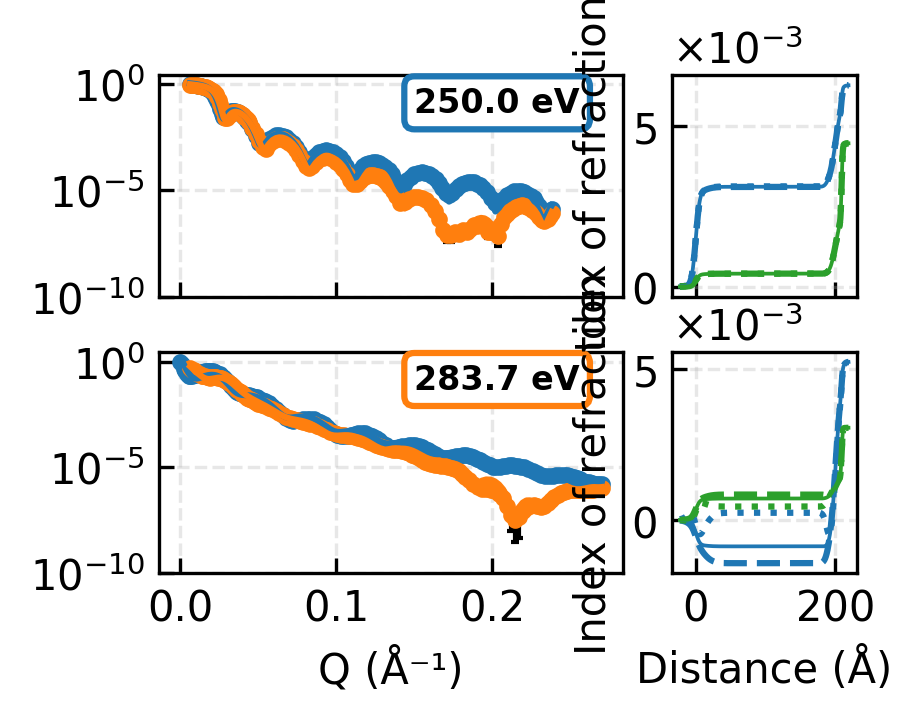

(<Figure size 900x600 with 4 Axes>,
 array([[<Axes: >, <Axes: ylabel='Index of refraction'>],
        [<Axes: xlabel='Q (Å⁻¹)'>,
         <Axes: xlabel='Distance (Å)', ylabel='Index of refraction'>]],
       dtype=object))

In [ ]:
from typing import Any, List
from matplotlib.figure import Figure


def plot_reflectivity_and_structure_from_list(
    objectives_list: List[Any], figsize=(12, 10)
) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a list of objectives.

    Parameters:
    -----------
    objectives_list : List[AnisotropyObjective]
        A list of objective objects to plot.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = objectives_list
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        sharex="col",
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
        dpi=300,
    )
    # share x allong the left collumn and right collumn but not across both

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        o.plot(ax=ax[i][0], show_anisotropy=False)
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)
        ax[i][0].set_yticks([1e-10, 1e-5, 1])

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            f"{energy_labels[i]:.1f} eV",
            transform=ax[i][0].transAxes,
            fontsize=8,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        if ax[i][0].get_legend():
            ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)
        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )
        if ax[i][1].get_legend():
            ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax


# Example usage:
# You can call this function with a subset of objectives from your fit_obj
objectives_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in [250.0, 283.7]
]
plot_reflectivity_and_structure_from_list(objectives_to_plot, figsize=(3, 2))

In [ ]:
from refnx.reflect.interface import Erf, Step


def orientation_profile(slabs, z=None, step=False):
    """
    Series of depth profiles for the slab model used to calculated p-RSoXR.

    Parameters
    ----------
    slabs : Information regarding the layer stack, see PXR_Structure class
    z : float
        Interfacial distance (Angstrom) measured from interface between the
        fronting medium and the first layer.
    step : Boolean
        Set 'True' for slab model without interfacial widths


    Returns
    -------
    zed : float / np.ndarray
        Depth into the film / Angstrom

    index_tensor : complex / np.ndarray
        Real and imaginary tensor components of index of refraction / unitless
        Array elements: [nxx, nyy, nzz]

    Optional:

    index_step : complex / np.ndarray
        Real and imaginary tensor components of index of refraction / unitless
        Calculated WITHOUT interfacial roughness

    Notes
    -----
    This can be called in vectorised fashion.

    To calculate the isotropic components:
        index_iso = index_tensor.sum(axis=1)/3 #(nxx + nyy + nzz)/3
    To calculate the birefringence/dichroism:
        diff = index_tensor[:,0] - index_tensor[:,2] #nxx - nzz

    """
    nlayers = (
        np.size(slabs, 0) - 2
    )  # Calculate total number of layers (not including fronting/backing)

    # work on a copy of the input array
    layers = np.copy(slabs)
    layers[:, 0] = np.fabs(slabs[:, 0])  # Ensure the thickness is positive
    layers[:, 3] = np.fabs(slabs[:, 3])  # Ensure the roughness is positive
    # bounding layers should have zero thickness
    layers[0, 0] = layers[-1, 0] = 0

    # distance of each interface from the fronting interface
    dist = np.cumsum(layers[:-1, 0])
    total_film_thickness = int(
        np.round(dist[-1])
    )  # Total film thickness for point density
    # workout how much space the SLD profile should encompass
    # (if z array not provided)
    if z is None:
        zstart = -5 - 4 * np.fabs(slabs[1, 3])
        zend = 5 + dist[-1] + 4 * layers[-1, 3]
        zed = np.linspace(
            zstart, zend, num=total_film_thickness * 2
        )  # 0.5 Angstrom resolution default
    else:
        zed = np.asfarray(z)  # type: ignore[assignment]
    tensor_erf = (
        np.ones((len(zed), 3), dtype=float) * reduced_tensor[0]
    )  # Full wave of initial conditions
    tensor_step = np.copy(tensor_erf)  # Full wave without interfacial roughness
    delta_n = reduced_tensor[1:] - reduced_tensor[:-1]  # Change in n at each interface

    # use erf for roughness function, but step if the roughness is zero
    step_f = Step()  # Step function (see refnx documentation)
    erf_f = Erf()  # Error function (see refnx documentation)
    sigma = layers[1:, 3]  # Interfacial width parameter

    # accumulate the SLD of each step.
    for i in range(nlayers + 1):
        f = erf_f
        g = step_f
        if sigma[i] == 0:
            f = step_f
        tensor_erf += (
            delta_n[None, i, :] * f(zed, scale=sigma[i], loc=dist[i])[:, None]
        )  # Broadcast into a single item
        tensor_step += (
            delta_n[None, i, :] * g(zed, scale=0, loc=dist[i])[:, None]
        )  # Broadcast into a single item

    return zed, tensor_erf if step is False else tensor_step

In [ ]:
fit_obj.objectives[0].model.structure.slabs()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.53154422e+00, 2.75377659e-03, 3.54585775e-04, 4.41162085e+00],
       [1.83322579e+02, 3.09786890e-03, 4.00093373e-04, 1.28185716e+01],
       [1.15022904e+01, 3.37941299e-03, 4.35514388e-04, 4.19499236e+00],
       [8.73050665e+00, 5.63719369e-03, 2.17944320e-03, 5.85627174e+00],
       [0.00000000e+00, 6.26193910e-03, 4.45694423e-03, 1.20000000e+00]])

In [ ]:
from refnx.reflect.interface import Erf, Step

orient = np.degrees([MA, 0.802, 1.207, 0.904, MA, MA])
errs = np.array([0, 0.457, 0.070, 0.577, 0, 0]) * 4
orient_lb = orient - errs
orient_ub = orient + errs
depth_profile_structure = fit_obj.objectives[0].model.structure

slabs = fit_obj.objectives[0].model.structure.slabs()
nlayers = (
    np.size(slabs, 0) - 2
)  # Calculate total number of layers (not including fronting/backing)

# work on a copy of the input array
layers = np.copy(slabs)
zstart = -5 * np.fabs(slabs[1, 3])
dist = np.cumsum(layers[:-1, 0])
zend = 5 + dist[-1] + 4 * layers[-1, 3]
offset = 3 * layers[-2, 3]
total_film_thickness = int(np.round(dist[-1])) + 10
zed = np.linspace(zstart - offset, zend + offset, total_film_thickness)
#  use the 4 * width of the second to last layer to set an offset

# dist -= offset

step_f = Step()  # Step function (see refnx documentation)
erf_f = Erf()  # Error function (see refnx documentation)
sigma = layers[1:, 3]  # Interfacial width parameter

rot_erf = np.degrees(MA)
rot_erf_lb = np.degrees(MA)
rot_erf_ub = np.degrees(MA)
rot_step = np.degrees(MA)
rot_step_lb = np.degrees(MA)
rot_step_ub = np.degrees(MA)
#  Get delta_r as the change in orientation at each interface from the list of orientations

diff_o = np.diff(orient)
diff_o_lb = np.diff(orient_lb)
diff_o_ub = np.diff(orient_ub)

# accumulate the SLD of each step.
for i in range(nlayers + 1):
    f = erf_f
    g = step_f
    if sigma[i] == 0:
        f = step_f
    rot_erf += diff_o[i] * f(
        zed, scale=sigma[i], loc=dist[i]
    )  # Broadcast into a single item
    rot_erf_lb += diff_o_lb[i] * f(
        zed, scale=sigma[i], loc=dist[i]
    )  # Broadcast into a single item
    rot_erf_ub += diff_o_ub[i] * f(
        zed, scale=sigma[i], loc=dist[i]
    )  # Broadcast into a single item
    rot_step += diff_o[i] * g(
        zed,
        loc=dist[i],
        scale=0,
    )  # Broadcast into a single item
    rot_step_lb += diff_o_lb[i] * g(
        zed,
        loc=dist[i],
        scale=0,
    )  # Broadcast into a single item
    rot_step_ub += diff_o_ub[i] * g(
        zed,
        loc=dist[i],
        scale=0,
    )  # Broadcast into a single item

#  find the halfway point between dists
midpoints = np.array([0.5 * (dist[i] + dist[i + 1]) for i in range(len(dist) - 1)])

mask1 = (zed > midpoints[0]) & (zed < midpoints[1])
mask2 = (zed > midpoints[1]) & (zed < midpoints[2])

zed1 = zed[mask1]
zed2 = zed[mask2]

rot_erf1 = rot_erf[mask1]
rot_erf2 = rot_erf[mask2]

midpoint_orientation_1 = 0.5 * (rot_erf1[0] + rot_erf1[-1])
midpoint_orientation_2 = 0.5 * (rot_erf2[0] + rot_erf2[-1])

print(f"Midpoint orientation 1: {midpoint_orientation_1}")
print(f"Midpoint orientation 2: {midpoint_orientation_2}")

#  find the zed value closest to these midpoint orientations
interface1 = zed1[np.abs(rot_erf1 - midpoint_orientation_1).argmin()]
interface2 = zed2[np.abs(rot_erf2 - midpoint_orientation_2).argmin()]

print(f"Interface 1: {interface1}")
print(f"Interface 2: {interface2}")

Midpoint orientation 1: 62.295801628765105
Midpoint orientation 2: 61.15791391830984
Interface 1: 13.704510540319212
Interface 2: 171.66432685924022


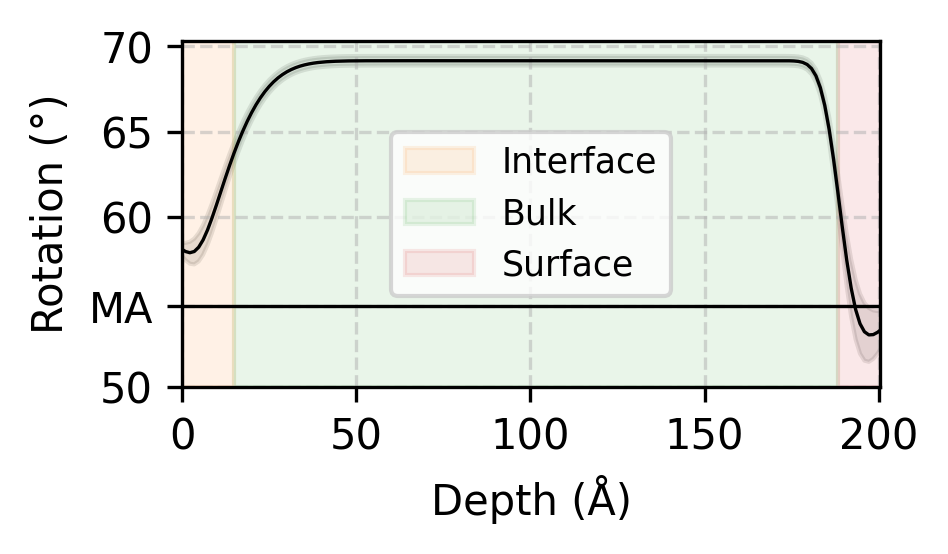

In [ ]:
#  plot the rot_erf vs zed
import matplotlib.pyplot as plt


def plot_rotation_profile(ax, zed, rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA):
    """
    Plots the rotation profile with error bands and layer spans.
    """
    ax.axhline(np.degrees(MA), color="k", lw=0.8)
    ax.plot(zed, rot_erf, linestyle="-", color="k", lw=0.8)
    ax.fill_between(zed, rot_erf_lb, rot_erf_ub, color="k", alpha=0.1)
    ax.set_xlabel("Depth (Å)")
    ax.set_ylabel("Rotation (°)")
    ax.set_yticks([50, np.degrees(MA), 60, 65, 70])
    ax.set_xlim(0, dist[-2])
    #  format the ticks to include the magic angle as a label
    ax.set_yticklabels(["50", "MA", "60", "65", "70"])
    ax.grid(True, linestyle="--", alpha=0.5)

    #  Define the interface boundaries from the half way orientation between subsequent
    #  slabs
    for i, slab in enumerate(slabs):
        if i == 0:
            ax.axvspan(
                0,
                interface1,
                color="C1",
                alpha=0.1,
                label="Interface",
            )
        elif i == 1:
            ax.axvspan(
                interface1,
                interface2,
                color="C2",
                alpha=0.1,
                label="Bulk",
            )
        elif i == 2:
            ax.axvspan(
                interface2,
                zed.max(),
                color="C3",
                alpha=0.1,
                label="Surface",
            )
    ax.legend(
        loc="center",
        fontsize="small",
    )
    return ax


fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)
plot_rotation_profile(ax, zed, rot_erf, rot_erf_lb, rot_erf_ub, slabs, dist, MA)
plt.show()

In [ ]:
#  set matplotlib ticks to point inward
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
# plt.rcParams["text.usetex"] = True
# Add ticks to the top and right side of every axis
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
# Set the grids so that they are dashed
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
# Ensure grids draw on minor ticks
plt.rcParams["axes.grid.which"] = "both"


/tmp/ipykernel_166101/543304152.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


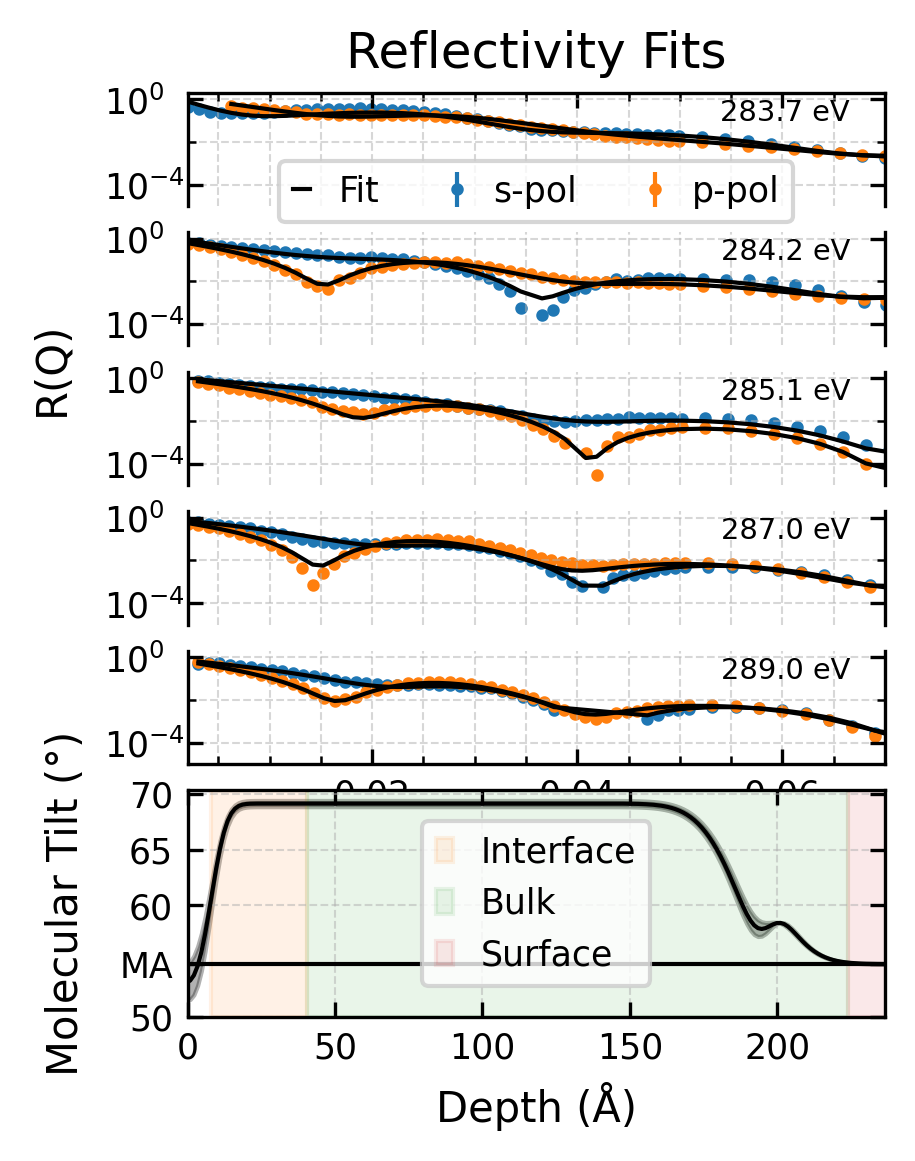

In [ ]:
from matplotlib.ticker import NullFormatter

# Create a figure with six subplots arranged vertically
# The top 5 are for reflectivity, the bottom one for the depth profile
fig, axes = plt.subplots(
    6,
    1,
    figsize=(3, 4),  # Adjusted figsize for better visibility
    dpi=300,
    gridspec_kw={"hspace": 0.2, "height_ratios": [1, 1, 1, 1, 1, 2]},
)


# --- Top 5 Subplots: Reflectivity Traces ---
# Grab every 5th energy
target_energy = energies[-5:]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

for i, obj in enumerate(objective_to_plot):
    # For the first subplot, it shares with no one yet.
    # For subsequent subplots (i > 0), share the x-axis with the first subplot (axes[0]).
    ax = axes[i]
    model = obj.model
    d = obj.data

    # Plot experimental data
    ax.errorbar(
        d.s.x,
        d.s.y,
        d.s.y_err,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol",
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y,
        d.p.y_err,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol",
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines
    ax.plot(d.s.x, model_s, color="k", lw=1, label="Fit")
    ax.plot(d.p.x, model_p, color="k", lw=1)

    ax.set_yscale("log")
    ax.text(
        0.95,
        0.95,
        f"{obj.model.energy} eV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize="x-small",
    )
    ax.set_xlim(0.002, 0.07)
    ax.minorticks_on()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Share x-axis with the first plot and remove tick labels for upper plots
    if i > 0:
        ax.sharex(axes[0])
    if i < 4:  # All but the last of the top 5 plots
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

    if i == 0:
        ax.legend(
            fontsize="small",
            loc="lower center",
            ncols=3,
            handlelength=0.5,
            bbox_to_anchor=(0.5, -0.3),
        )
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(
            axis="x", which="both", bottom=False, top=True, labelbottom=False
        )
    elif i < 4:
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    else:
        ax.tick_params(axis="x", which="both", top=False)
        ax.spines["top"].set_visible(False)
    # Set major ticks
    ax.set_yticks([1e-4, 1])
    # Set minor ticks
    ax.set_yticks([1e-2], minor=True)
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(bottom=1e-5, top=2)
    # set the tick label font
    ax.tick_params(axis="y", which="major", pad=20)
    ax.tick_params(axis="both", labelsize="small")
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("left")

# Add a single y-label for the top 5 plots
fig.text(-0.05, 0.65, "R(Q)", va="center", rotation="vertical")


# Set common properties for top plots
axes[0].set_title("Reflectivity Fits")
axes[4].set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = axes[5]
ax_bottom.axhline(np.degrees(MA), color="k", lw=1)
ax_bottom.plot(zed, rot_erf[::-1], linestyle="-", color="k", lw=1)
ax_bottom.fill_between(zed, rot_erf_lb[::-1], rot_erf_ub[::-1], color="k", alpha=0.3)
ax_bottom.set_xlabel("Depth (Å)")
ax_bottom.set_ylabel("Molecular Tilt (°)")
ax_bottom.set_yticks([50, np.degrees(MA), 60, 65, 70])
ax_bottom.set_xlim(0, zed.max())
#  format the ticks to include the magic angle as a label
ax_bottom.set_yticklabels(["50", "MA", "60", "65", "70"])
ax_bottom.grid(True, linestyle="--", alpha=0.5)
ax_bottom.tick_params(axis="both", labelsize="small")

for i, slab in enumerate(slabs):
    if i == 0:
        ax_bottom.axvspan(
            offset // 2, dist[1] + 2 * offset, color="C1", alpha=0.1, label="Interface"
        )
    elif i == 1:
        ax_bottom.axvspan(
            dist[1] + 2 * offset,
            dist[2] + 2 * offset,
            color="C2",
            alpha=0.1,
            label="Bulk",
        )
    elif i == 2:
        ax_bottom.axvspan(
            dist[2] + 2 * offset,
            dist[3] + 2.5 * offset,
            color="C3",
            alpha=0.1,
            label="Surface",
        )
ax_bottom.legend(
    loc="center",
    fontsize="small",
    handlelength=0.5,
)

fig.tight_layout()
fig.align_labels()
plt.show()


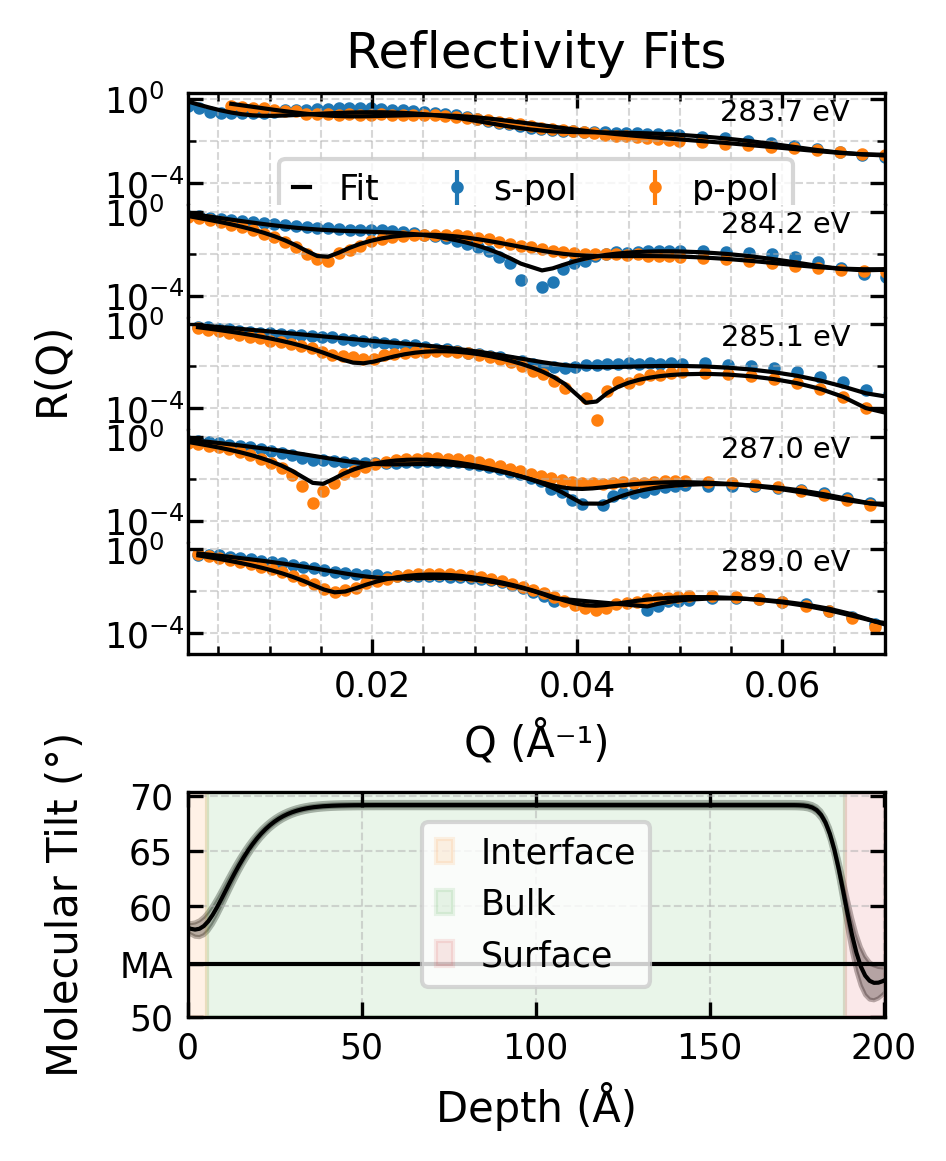

In [ ]:
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 4), dpi=300)

# Create a 2-row GridSpec for the main layout
# The top part for reflectivity plots will be larger
# hspace controls the space between the two main sections
gs_main = gridspec.GridSpec(2, 1, height_ratios=[5, 2], hspace=0.35, figure=fig)

# Create a nested GridSpec for the 5 reflectivity plots in the top part
# hspace=0 here makes them stick together vertically
gs_refl = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs_main[0], hspace=0.01)

axes_refl = []
axes_refl.append(fig.add_subplot(gs_refl[0]))
for i in range(1, 5):
    axes_refl.append(fig.add_subplot(gs_refl[i], sharex=axes_refl[0]))


# --- Top 5 Subplots: Reflectivity Traces ---
# Grab every 5th energy
target_energy = energies[-5:]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

for i, obj in enumerate(objective_to_plot):
    ax = axes_refl[i]
    model = obj.model
    d = obj.data

    # Plot experimental data
    ax.errorbar(
        d.s.x,
        d.s.y,
        d.s.y_err,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol",
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y,
        d.p.y_err,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol",
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines
    ax.plot(d.s.x, model_s, color="k", lw=1, label="Fit")
    ax.plot(d.p.x, model_p, color="k", lw=1)

    ax.set_yscale("log")
    ax.text(
        0.95,
        0.95,
        f"{obj.model.energy} eV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize="x-small",
    )
    ax.set_xlim(0.002, 0.07)
    ax.minorticks_on()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Share x-axis with the first plot and remove tick labels for upper plots
    if i < 4:  # All but the last of the top 5 plots
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

    if i == 0:
        ax.legend(
            fontsize="small",
            loc="lower center",
            ncols=3,
            handlelength=0.5,
            bbox_to_anchor=(0.5, -0.3),
        )
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(
            axis="x", which="both", bottom=False, top=True, labelbottom=False
        )
    elif i < 4:
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    else:
        ax.tick_params(axis="x", which="both", top=False)
        ax.spines["top"].set_visible(False)
    # Set major ticks
    ax.set_yticks([1e-4, 1])
    # Set minor ticks
    ax.set_yticks([1e-2], minor=True)
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(bottom=1e-5, top=2)
    # set the tick label font
    ax.tick_params(axis="y", which="major", pad=20)
    ax.tick_params(axis="both", labelsize="small")
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("left")

# Add a single y-label for the top 5 plots
fig.text(-0.05, 0.65, "R(Q)", va="center", rotation="vertical")


# Set common properties for top plots
axes_refl[0].set_title("Reflectivity Fits")
axes_refl[4].set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = fig.add_subplot(gs_main[1])
ax_bottom.axhline(np.degrees(MA), color="k", lw=1)
ax_bottom.plot(zed, rot_erf, linestyle="-", color="k", lw=1)
ax_bottom.fill_between(zed, rot_erf_lb, rot_erf_ub, color="k", alpha=0.3)
ax_bottom.set_xlabel("Depth (Å)")
ax_bottom.set_ylabel("Molecular Tilt (°)")
ax_bottom.set_yticks([50, np.degrees(MA), 60, 65, 70])
ax_bottom.set_xlim(0, dist[-2])
#  format the ticks to include the magic angle as a label
ax_bottom.set_yticklabels(["50", "MA", "60", "65", "70"])
ax_bottom.grid(True, linestyle="--", alpha=0.5)
ax_bottom.tick_params(axis="both", labelsize="small")

for i, slab in enumerate(slabs):
    if i == 0:
        ax_bottom.axvspan(dist[0], dist[1], color="C1", alpha=0.1, label="Interface")
    elif i == 1:
        ax_bottom.axvspan(
            dist[1],
            dist[2],
            color="C2",
            alpha=0.1,
            label="Bulk",
        )
    elif i == 2:
        ax_bottom.axvspan(
            dist[2],
            dist[3],
            color="C3",
            alpha=0.1,
            label="Surface",
        )
ax_bottom.legend(
    loc="center",
    fontsize="small",
    handlelength=0.5,
)

fig.align_labels()
plt.show()

/tmp/ipykernel_166101/1964971023.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


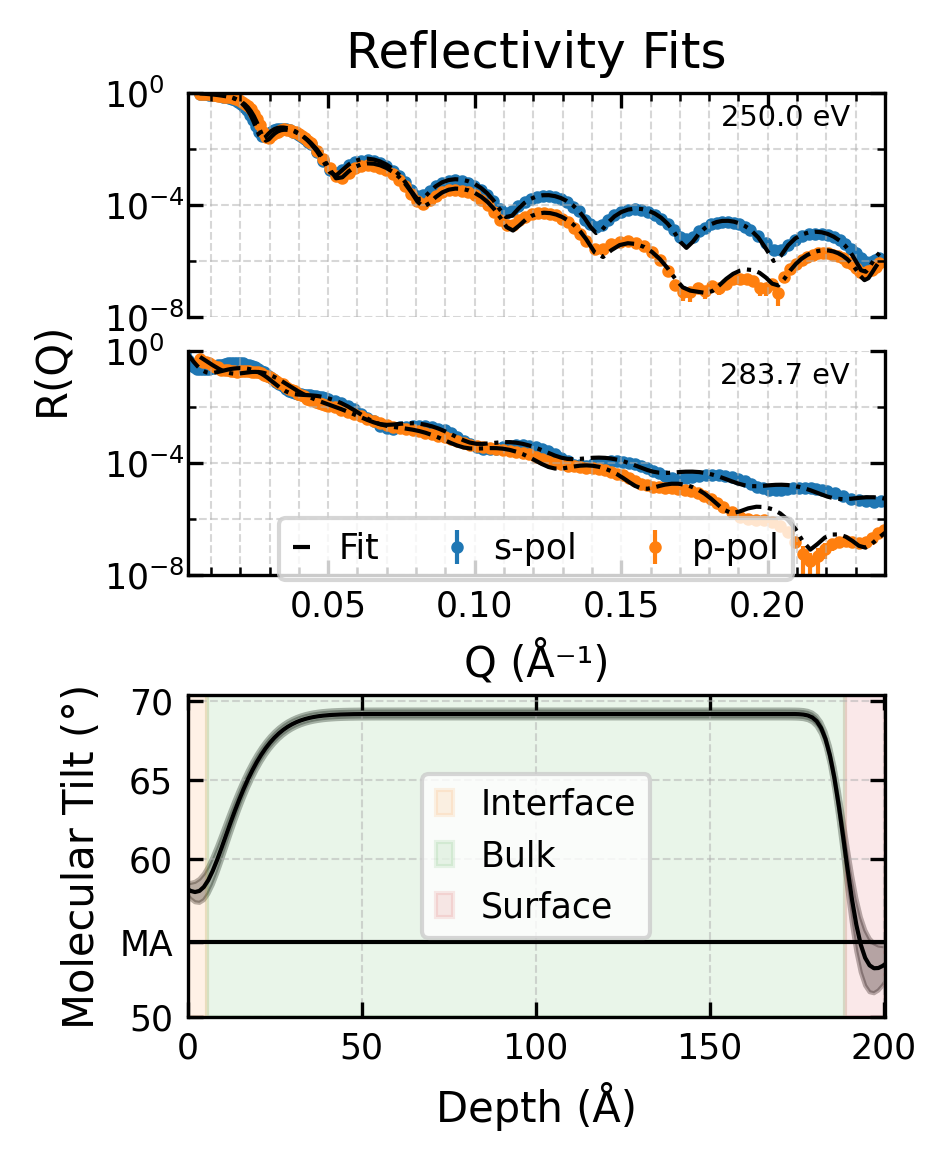

In [ ]:
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 4), dpi=300)

# Create a 2-row GridSpec for the main layout
# The top part for reflectivity plots will be larger
# Increased hspace to prevent label overlap
gs_main = gridspec.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.3, figure=fig)

# Create a nested GridSpec for the 5 reflectivity plots in the top part
# hspace=0 here makes them stick together vertically
gs_refl = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_main[0], hspace=0.15)

axes_refl = []
axes_refl.append(fig.add_subplot(gs_refl[0]))
axes_refl.append(fig.add_subplot(gs_refl[1], sharex=axes_refl[0]))


# --- Top 5 Subplots: Reflectivity Traces ---
# Grab every 5th energy
target_energy = [250, 283.7]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

for i, obj in enumerate(objective_to_plot):
    ax = axes_refl[i]
    model = obj.model
    d = obj.data

    # Plot experimental data
    ax.errorbar(
        d.s.x,
        d.s.y,
        d.s.y_err,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol",
        zorder=-1,
    )
    ax.errorbar(
        d.p.x,
        d.p.y,
        d.p.y_err,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol",
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines
    ax.plot(d.s.x, model_s, color="k", lw=1, label="Fit", ls="-.")
    ax.plot(d.p.x, model_p, color="k", lw=1, ls="-.")

    ax.set_yscale("log")
    ax.text(
        0.95,
        0.95,
        f"{obj.model.energy} eV",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize="x-small",
    )
    ax.set_xlim(0.002, 0.24)
    ax.minorticks_on()
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    # Share x-axis with the first plot and remove tick labels for upper plots
    if i < 1:  # All but the last of the top 5 plots
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.set_xlabel("")

    if i == 0:
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(
            axis="x", which="both", bottom=False, top=True, labelbottom=False
        )
    # elif i < 4:
    #     ax.tick_params(
    #         axis="x", which="both", bottom=False, top=False, labelbottom=False
    #     )
    #     ax.spines["top"].set_visible(False)
    #     ax.spines["bottom"].set_visible(False)
    else:
        ax.tick_params(axis="x", which="both", top=False)
        ax.spines["top"].set_visible(False)
        ax.legend(
            fontsize="small",
            loc="lower center",
            ncols=3,
            handlelength=0.5,
            bbox_to_anchor=(0.5, -0.1),  # Move legend slightly lower to avoid overlap
        )
    # Set major ticks
    ax.set_yticks([1e-8, 1e-4, 1])
    ax.set_yticks([1e-6, 1e-2], minor=True)
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_ylim(bottom=1e-8, top=1)
    # set the tick label font
    ax.tick_params(axis="y", which="major", pad=20)
    ax.tick_params(axis="both", labelsize="small")
    for label in ax.get_yticklabels():
        label.set_horizontalalignment("left")

# Add a single y-label for the top 5 plots
fig.text(-0.05, 0.65, "R(Q)", va="center", rotation="vertical")


# Set common properties for top plots
axes_refl[0].set_title("Reflectivity Fits")
axes_refl[1].set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = fig.add_subplot(gs_main[1])
ax_bottom.axhline(np.degrees(MA), color="k", lw=1)
ax_bottom.plot(zed, rot_erf, linestyle="-", color="k", lw=1)
ax_bottom.fill_between(zed, rot_erf_lb, rot_erf_ub, color="k", alpha=0.3)
ax_bottom.set_xlabel("Depth (Å)")
ax_bottom.set_ylabel("Molecular Tilt (°)")
ax_bottom.set_yticks([50, np.degrees(MA), 60, 65, 70])
ax_bottom.set_xlim(0, dist[-2])
#  format the ticks to include the magic angle as a label
ax_bottom.set_yticklabels(["50", "MA", "60", "65", "70"])
ax_bottom.grid(True, linestyle="--", alpha=0.5)
ax_bottom.tick_params(axis="both", labelsize="small")

for i, slab in enumerate(slabs):
    if i == 0:
        ax_bottom.axvspan(dist[0], dist[1], color="C1", alpha=0.1, label="Interface")
    elif i == 1:
        ax_bottom.axvspan(
            dist[1],
            dist[2],
            color="C2",
            alpha=0.1,
            label="Bulk",
        )
    elif i == 2:
        ax_bottom.axvspan(
            dist[2],
            dist[3],
            color="C3",
            alpha=0.1,
            label="Surface",
        )
ax_bottom.legend(
    loc="center",
    fontsize="small",
    handlelength=0.5,
)

# Use tight_layout instead of align_labels for better spacing
plt.tight_layout()
plt.show()

/tmp/ipykernel_166101/3366423688.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


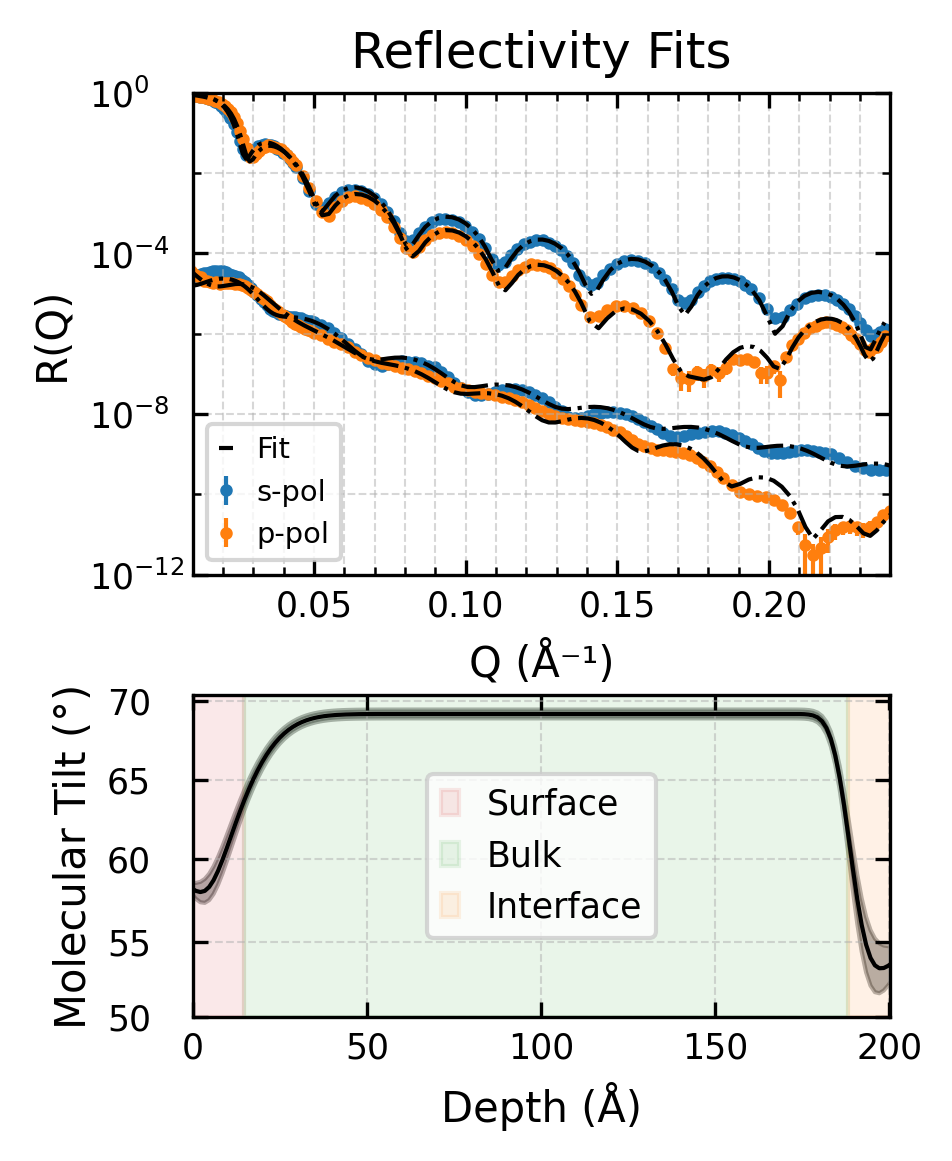

In [ ]:
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(3, 4), dpi=300)

# Create a 2-row GridSpec for the main layout
# The top part for reflectivity plot, bottom for depth profile
gs_main = gridspec.GridSpec(2, 1, height_ratios=[3, 2], hspace=0.3, figure=fig)

# Create a single axes for the combined reflectivity plot
ax_refl = fig.add_subplot(gs_main[0])

# --- Combined Reflectivity Plot ---
# Get the two energies to plot
target_energy = [250, 283.7]
objective_to_plot = [
    obj for obj in fit_obj.objectives if obj.model.energy in target_energy
]

offset_factor = 1e-4  # Offset for the second plot

for i, obj in enumerate(objective_to_plot):
    model = obj.model
    d = obj.data

    # Apply offset to the second plot (i=1)
    offset = offset_factor if i == 1 else 1.0

    # Plot experimental data
    ax_refl.errorbar(
        d.s.x,
        d.s.y * offset,
        d.s.y_err * offset,
        marker="o",
        color="C0",
        ms=2,
        lw=0,
        elinewidth=1,
        label="s-pol" if i == 0 else None,
        zorder=-1,
    )
    ax_refl.errorbar(
        d.p.x,
        d.p.y * offset,
        d.p.y_err * offset,
        marker="o",
        color="C1",
        ms=2,
        lw=0,
        elinewidth=1,
        label="p-pol" if i == 0 else None,
        zorder=-1,
    )

    # Calculate model reflectivity
    model_s = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="s",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.s.x)
    model_p = fit.ReflectModel(
        model.structure,
        energy=obj.model.energy,
        pol="p",
        name="",
        scale_s=model.scale_s,
        scale_p=model.scale_p,
        bkg=model.bkg,
        theta_offset_s=model.theta_offset_s,
        theta_offset_p=model.theta_offset_p,
        backend="uni",
    )(d.p.x)

    # Plot the fit lines with offset
    ax_refl.plot(
        d.s.x,
        model_s * offset,
        color="k",
        lw=1,
        ls="-.",
        label="Fit" if i == 0 else None,
    )
    ax_refl.plot(d.p.x, model_p * offset, color="k", lw=1, ls="-.")

ax_refl.set_yscale("log")
ax_refl.set_xlim(0.01, 0.24)
ax_refl.minorticks_on()
ax_refl.grid(True, which="both", linestyle="--", alpha=0.5)

# Set major ticks
ax_refl.set_yticks([1e-12, 1e-8, 1e-4, 1])
ax_refl.set_yticks([1e-10, 1e-6, 1e-2], minor=True)
ax_refl.yaxis.set_minor_formatter(NullFormatter())
ax_refl.set_ylim(bottom=1e-12, top=1)

# set the tick label font
ax_refl.tick_params(axis="y", which="major", pad=25)
ax_refl.tick_params(axis="both", labelsize="small")
for label in ax_refl.get_yticklabels():
    label.set_horizontalalignment("left")

# Add legend
ax_refl.legend(
    fontsize="x-small",
    loc="lower left",
    handlelength=0.5,
)

# Add y-label
ax_refl.set_ylabel("R(Q)", rotation="vertical")
ax_refl.set_title("Reflectivity Fits")
ax_refl.set_xlabel("Q (Å⁻¹)")

# --- Bottom Subplot: Orientation Depth Profile ---
ax_bottom = fig.add_subplot(gs_main[1])
# ax_bottom.axhline(np.degrees(MA), color="k", lw=1)
ax_bottom.plot(zed, rot_erf, linestyle="-", color="k", lw=1)
ax_bottom.fill_between(zed, rot_erf_lb, rot_erf_ub, color="k", alpha=0.3)
ax_bottom.set_xlabel("Depth (Å)")
ax_bottom.set_ylabel("Molecular Tilt (°)", labelpad=3)
ax_bottom.set_yticks([50, np.degrees(MA), 60, 65, 70])
ax_bottom.set_xlim(0, dist[-2])
#  format the ticks to include the magic angle as a label
ax_bottom.set_yticklabels(["50", "55", "60", "65", "70"])
ax_bottom.grid(True, linestyle="--", alpha=0.5)
ax_bottom.tick_params(axis="both", labelsize="small")
ax_bottom.tick_params(axis="y", which="major", pad=10)

for i, slab in enumerate(slabs):
    if i == 0:
        ax_bottom.axvspan(0, interface1, color="C3", alpha=0.1, label="Surface")
    elif i == 1:
        ax_bottom.axvspan(
            interface1,
            interface2,
            color="C2",
            alpha=0.1,
            label="Bulk",
        )
    elif i == 2:
        ax_bottom.axvspan(
            interface2,
            zed.max(),
            color="C1",
            alpha=0.1,
            label="Interface",
        )
ax_bottom.legend(
    loc="center",
    fontsize="small",
    handlelength=0.5,
)

# Use tight_layout instead of align_labels for better spacing
plt.tight_layout()
plt.show()